### Librerias

In [229]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy import stats
from statistics import mode
import warnings
import pycircular
import matplotlib.pyplot as plt
from IPython.display import display, HTML
warnings.filterwarnings('ignore')
from scipy.stats import pearsonr


In [230]:
# Carga el archivo CSV en un DataFrame
df = pd.read_csv('df_limpio.csv')

### Odontologos

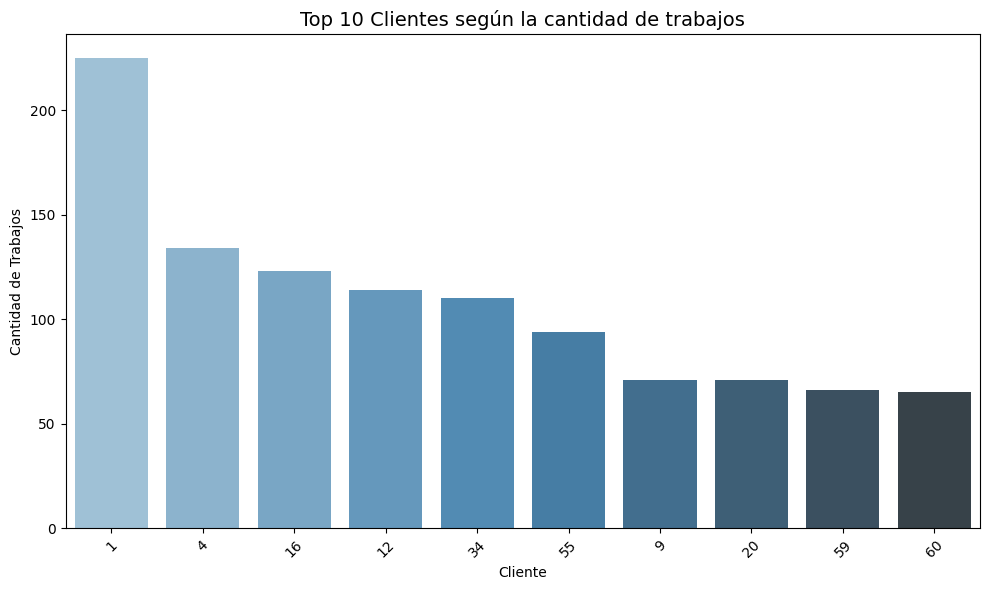

In [273]:
## TOP 5 clientes con más trabajos

# Agrupar por cliente y contar el número de IDs de trabajo únicos
clientes_top5 = df.groupby('Cliente')['Nº'].nunique().nlargest(10)

# Crear un gráfico de barras con los top 5 clientes ordenados de mayor a menor
plt.figure(figsize=(10, 6))
sns.barplot(x=clientes_top5.index, y=clientes_top5.values, order=clientes_top5.index, palette='Blues_d')

# Agregar títulos y etiquetas
plt.title("Top 10 Clientes según la cantidad de trabajos", fontsize=14)
plt.xlabel("Cliente")
plt.ylabel("Cantidad de Trabajos")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [232]:
# # trabajos Odontologo 1

# Convertir la columna 'Atrasado' a valores booleanos (True para 'SI' y False para 'NO')
df['Atrasado_bool'] = df['Atrasado'].apply(lambda x: True if x == 'SI' else False)

# Obtener los top 5 clientes
top5_clientes = clientes_top5.index[:1]

# Filtrar los trabajos de los top 5 clientes
trabajos_top5 = df[df['Cliente'].isin(top5_clientes)]

# Asegurarse de considerar trabajos únicos basados en el ID
trabajos_top5 = trabajos_top5.drop_duplicates(subset='Nº')

# Calcular el número total de trabajos únicos enviados por cada cliente
cantidad_trabajos = trabajos_top5.groupby('Cliente')['Nº'].count()

# Calcular el porcentaje de trabajos atrasados por cada cliente considerando IDs únicos
porcentaje_atrasados = trabajos_top5.groupby('Cliente').apply(lambda x: (x['Atrasado_bool'].sum() / len(x)) * 100)

# Mostrar cantidad de trabajos y porcentaje de trabajos atrasados
resultados = pd.DataFrame({
    'Cantidad de trabajos': cantidad_trabajos,
    'Porcentaje de atrasados': porcentaje_atrasados
})

print(resultados)


         Cantidad de trabajos  Porcentaje de atrasados
Cliente                                               
1                         232                32.758621


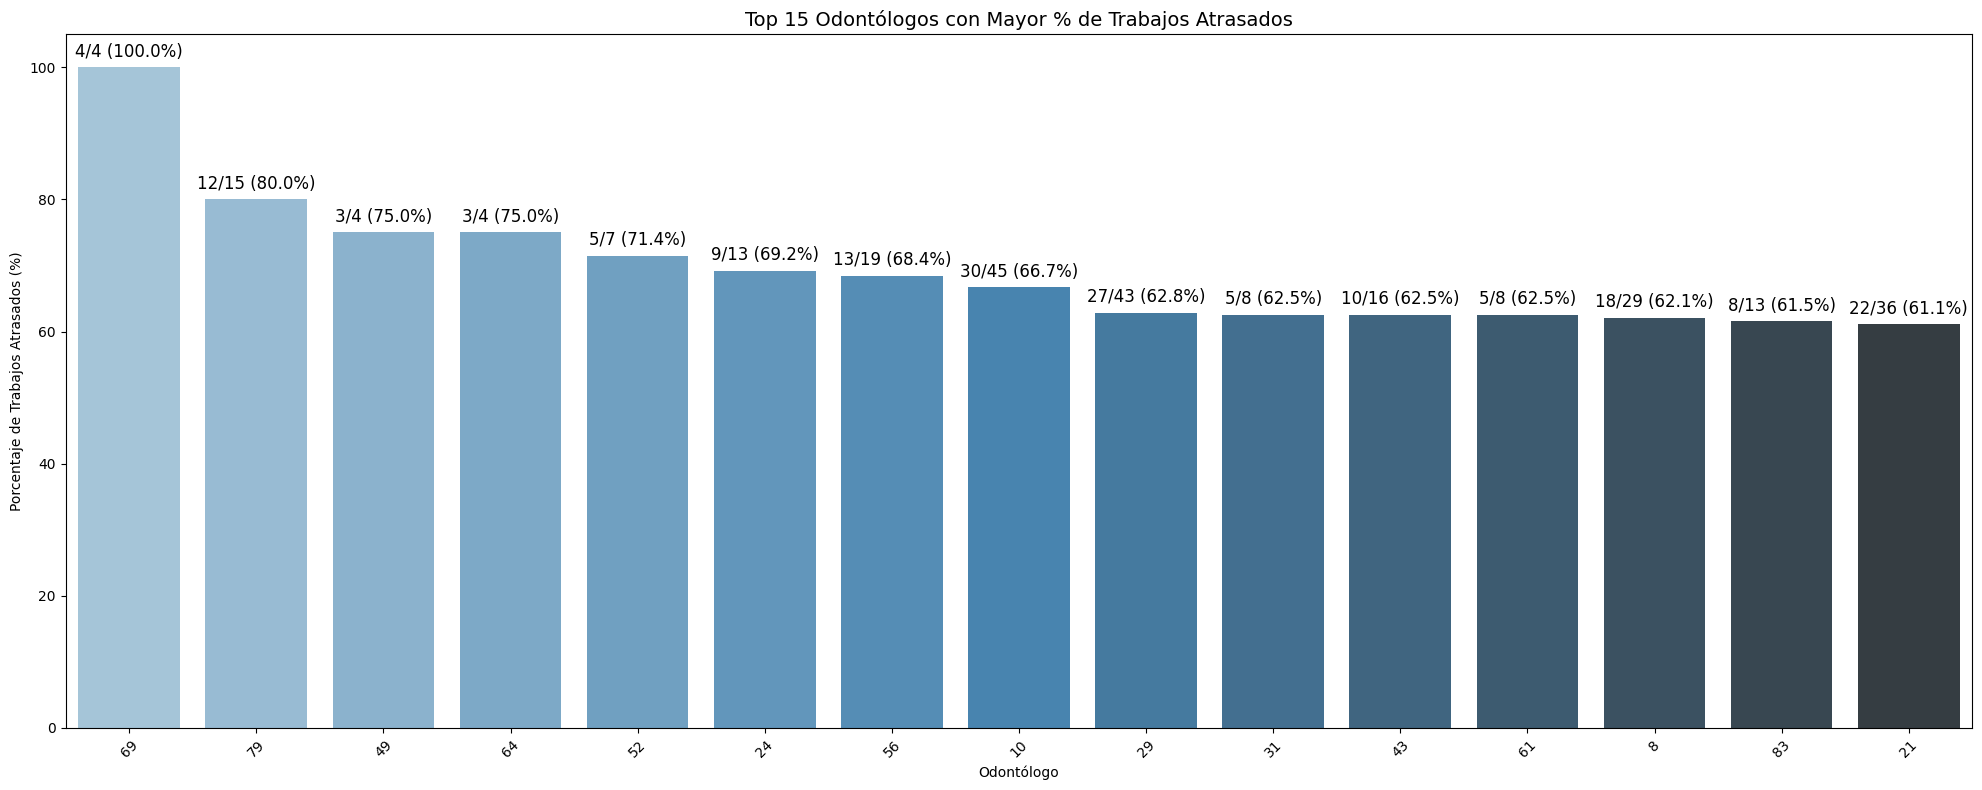

In [276]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ejemplo de datos (asegúrate de adaptar esto a tu DataFrame)
# df = pd.read_csv('ruta_a_tu_archivo.csv')

# Filtrar los registros donde el trabajo está retrasado
df_atrasado = df[df['Atrasado'] == 'SI']

# Calcular el total de trabajos enviados por cada odontólogo
total_trabajos = df.groupby('Cliente')['Nº'].nunique()

# Filtrar los odontólogos con más de 3 trabajos
total_trabajos_mas_3 = total_trabajos[total_trabajos > 3]

# Calcular el número de trabajos atrasados por odontólogo, solo para aquellos con más de 3 trabajos
trabajos_atrasados = df_atrasado.groupby('Cliente')['Nº'].nunique()

# Filtrar los odontólogos con más de 3 trabajos en la lista de trabajos atrasados
trabajos_atrasados = trabajos_atrasados[trabajos_atrasados.index.isin(total_trabajos_mas_3.index)]

# Calcular el porcentaje de trabajos atrasados por odontólogo
porcentaje_atrasos = (trabajos_atrasados / total_trabajos_mas_3) * 100

# Filtrar los 15 odontólogos con el mayor porcentaje de trabajos atrasados
odontologos_top15 = porcentaje_atrasos.nlargest(15)

# Crear un gráfico de barras con los 15 odontólogos con mayor % de trabajos atrasados
plt.figure(figsize=(20, 8))
ax = sns.barplot(x=odontologos_top15.index, y=odontologos_top15.values, order=odontologos_top15.index, palette='Blues_d')

# Agregar la cantidad de trabajos atrasados y el total encima de las barras
for i, odontologo in enumerate(odontologos_top15.index):
    atrasos = trabajos_atrasados[odontologo]
    total = total_trabajos_mas_3[odontologo]
    texto = f'{atrasos}/{total} ({porcentaje_atrasos[odontologo]:.1f}%)'
    ax.text(i, odontologos_top15.values[i] + 1, texto, ha='center', va='bottom', fontsize=12)

# Agregar títulos y etiquetas
plt.title("Top 15 Odontólogos con Mayor % de Trabajos Atrasados", fontsize=14)
plt.xlabel("Odontólogo")
plt.ylabel("Porcentaje de Trabajos Atrasados (%)")
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### Series de tiempo

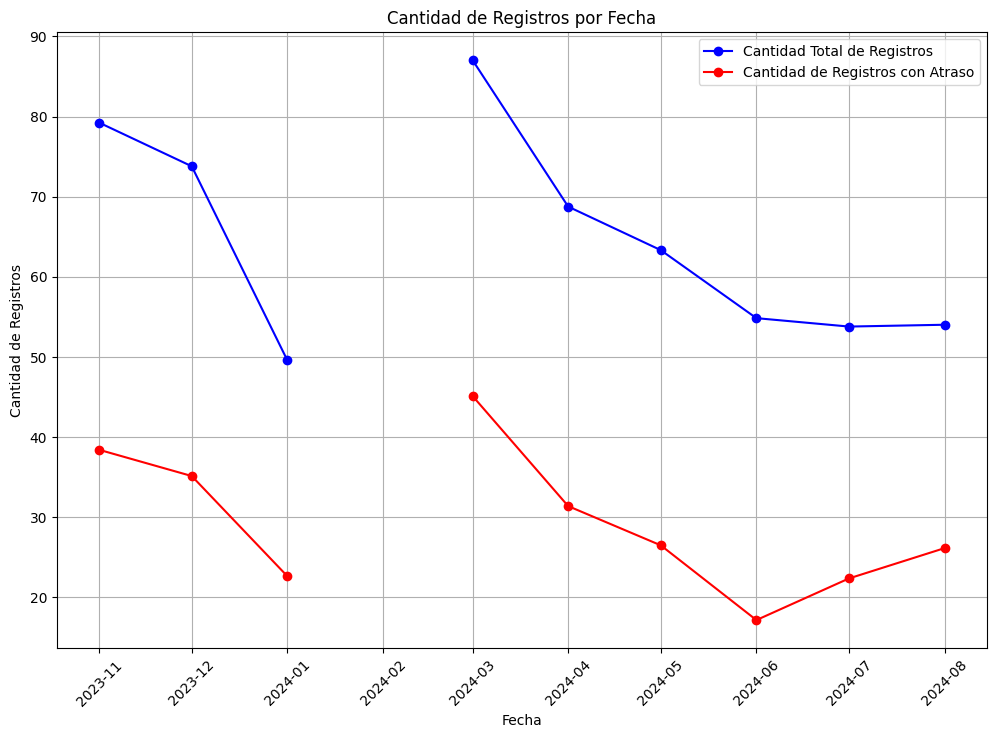

In [234]:
# Grafico

import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que la columna 'Fecha entrada' sea de tipo datetime
df['Fecha entrada'] = pd.to_datetime(df['Fecha entrada'], format='%Y-%m-%d %H:%M:%S')


# Filtrar datos a partir del 1 de noviembre de 2023
fecha_inicio = pd.Timestamp('2023-11-01')
df = df[df['Fecha entrada'] >= fecha_inicio]

# Primer conjunto de datos: Total de registros
df_total = df.groupby(df['Fecha entrada'].dt.date).size().reset_index(name='cantidad_de_registros_total')
df_total.rename(columns={'index': 'Fecha entrada'}, inplace=True)
df_total['Fecha entrada'] = pd.to_datetime(df_total['Fecha entrada'])
df_total.set_index('Fecha entrada', inplace=True)
y_total = df_total['cantidad_de_registros_total'].resample('MS').mean()

# Segundo conjunto de datos: Registros con atraso
df_atraso = df[df['Atrasado'] == 'SI']
df_atraso = df_atraso.groupby(df_atraso['Fecha entrada'].dt.date).size().reset_index(name='cantidad_de_registros_atraso')
df_atraso.rename(columns={'index': 'Fecha entrada'}, inplace=True)
df_atraso['Fecha entrada'] = pd.to_datetime(df_atraso['Fecha entrada'])
df_atraso.set_index('Fecha entrada', inplace=True)
y_atraso = df_atraso['cantidad_de_registros_atraso'].resample('MS').mean()

# Graficar ambos conjuntos de datos
plt.figure(figsize=(12, 8))

plt.plot(y_total.index, y_total, marker='o', linestyle='-', color='b', label='Cantidad Total de Registros')
plt.plot(y_atraso.index, y_atraso, marker='o', linestyle='-', color='r', label='Cantidad de Registros con Atraso')

# Configurar títulos y etiquetas
plt.title('Cantidad de Registros por Fecha')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Registros')
plt.grid(True)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para mejor legibilidad
plt.legend()

# Mostrar el gráfico
plt.show()

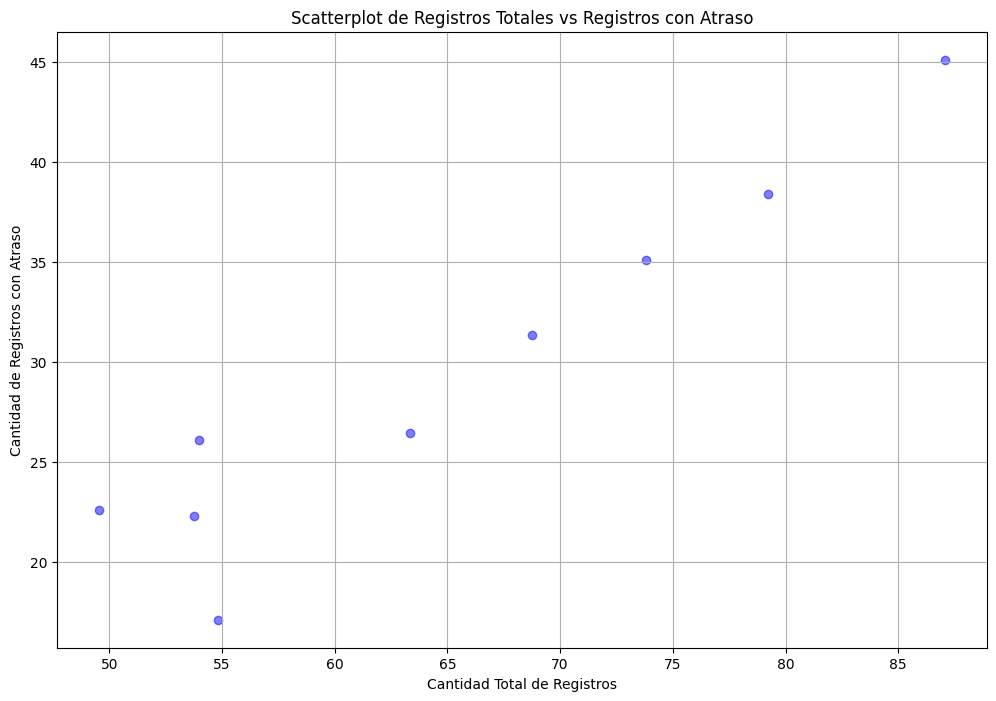

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegúrate de que la columna 'Fecha entrada' sea de tipo datetime
df['Fecha entrada'] = pd.to_datetime(df['Fecha entrada'], format='%Y-%m-%d %H:%M:%S')

# Filtrar datos a partir del 1 de noviembre de 2023
fecha_inicio = pd.Timestamp('2023-11-01')
df = df[df['Fecha entrada'] >= fecha_inicio]

# Primer conjunto de datos: Total de registros
df_total = df.groupby(df['Fecha entrada'].dt.date).size().reset_index(name='cantidad_de_registros_total')
df_total.rename(columns={'index': 'Fecha entrada'}, inplace=True)
df_total['Fecha entrada'] = pd.to_datetime(df_total['Fecha entrada'])
df_total.set_index('Fecha entrada', inplace=True)
df_total = df_total.resample('MS').mean().reset_index()

# Segundo conjunto de datos: Registros con atraso
df_atraso = df[df['Atrasado'] == 'SI']
df_atraso = df_atraso.groupby(df_atraso['Fecha entrada'].dt.date).size().reset_index(name='cantidad_de_registros_atraso')
df_atraso.rename(columns={'index': 'Fecha entrada'}, inplace=True)
df_atraso['Fecha entrada'] = pd.to_datetime(df_atraso['Fecha entrada'])
df_atraso.set_index('Fecha entrada', inplace=True)
df_atraso = df_atraso.resample('MS').mean().reset_index()

# Combinar ambos conjuntos de datos en un solo DataFrame para el scatterplot
df_combined = pd.merge(df_total, df_atraso, on='Fecha entrada', how='outer')

# Graficar scatterplot
plt.figure(figsize=(12, 8))

plt.scatter(df_combined['cantidad_de_registros_total'], df_combined['cantidad_de_registros_atraso'], color='b', alpha=0.5)

# Configurar títulos y etiquetas
plt.title('Scatterplot de Registros Totales vs Registros con Atraso')
plt.xlabel('Cantidad Total de Registros')
plt.ylabel('Cantidad de Registros con Atraso')
plt.grid(True)

# Mostrar el gráfico
plt.show()


In [236]:
# relacion lineal

# Alinear las dos series para asegurarse de que tengan el mismo índice
y_total, y_atraso = y_total.align(y_atraso, join='inner')

# Eliminar NaN e Inf de ambas series
mask = ~np.isnan(y_total) & ~np.isnan(y_atraso) & ~np.isinf(y_total) & ~np.isinf(y_atraso)

y_total_clean = y_total[mask]
y_atraso_clean = y_atraso[mask]

# Verificar que las series no estén vacías después de la limpieza
if len(y_total_clean) > 1 and len(y_atraso_clean) > 1:
    # Calcular la correlación de Pearson
    corr_coef, p_value = pearsonr(y_total_clean, y_atraso_clean)

    # Imprimir los resultados
    print(f"Coeficiente de correlación de Pearson: {corr_coef}")
    print(f"Valor p: {p_value}")
else:
    print("No hay suficientes datos después de eliminar NaN/Inf para calcular la correlación.")


Coeficiente de correlación de Pearson: 0.9486927073837758
Valor p: 9.578530301118782e-05


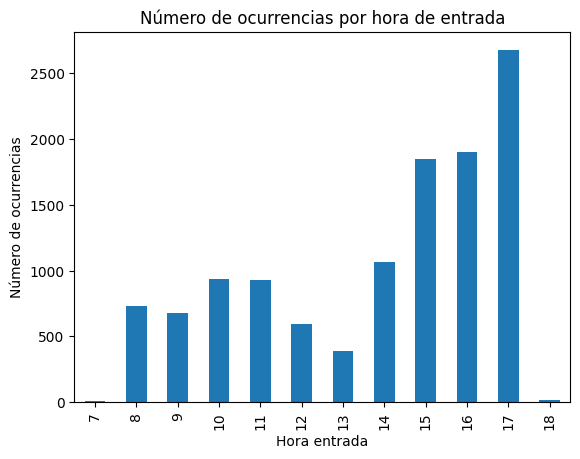

In [237]:
#  frecuencia de entrada por hora

# Asegúrate de que 'Fecha entrada' sea un objeto datetime
df['Fecha entrada'] = pd.to_datetime(df['Fecha entrada'])

# Agrupar por la hora de 'Fecha entrada' y contar el número de ocurrencias
conteo_por_hora = df.groupby(df['Fecha entrada'].dt.hour)['Nº'].count()

# Crear el gráfico de barras
ax = conteo_por_hora.plot(kind='bar')

# Configurar el texto del eje x
ax.set_xlabel('Hora entrada')
ax.set_ylabel('Número de ocurrencias')
ax.set_title('Número de ocurrencias por hora de entrada')

# Mostrar el gráfico
plt.show()



### R/A

In [238]:
import numpy as np

# Calcular el número total de registros
total_registros = df.shape[0]

# Calcular cuántos registros deben tener "A" y "R"
cantidad_a = int(total_registros * 0.0519)
cantidad_r = int(total_registros * 0.04035)

# Calcular cuántos de esos deben tener "Atraso" = "SI" según el porcentaje deseado
cantidad_a_si = int(cantidad_a * 0.952)
cantidad_r_si = int(cantidad_r * 0.835)

# Crear una nueva columna con "-" como valor por defecto
df['Repetición|Ajuste'] = "-"

# Asignar "A" a una muestra aleatoria de los registros donde "Atraso" = "SI"
df_atraso_si = df[df['Atrasado'] == "SI"]
indices_a_si = np.random.choice(df_atraso_si.index, size=cantidad_a_si, replace=False)
df.loc[indices_a_si, 'Repetición|Ajuste'] = "A"

# Asignar el restante 4.8% de "A" a registros donde "Atraso" = "NO"
df_atraso_no = df[df['Atrasado'] != "SI"]
cantidad_a_no = cantidad_a - cantidad_a_si
indices_a_no = np.random.choice(df_atraso_no.index, size=cantidad_a_no, replace=False)
df.loc[indices_a_no, 'Repetición|Ajuste'] = "A"

# Asignar "R" a una muestra aleatoria de los registros donde "Atraso" = "SI"
indices_r_si = np.random.choice(df_atraso_si[df_atraso_si['Repetición|Ajuste'] == "-"].index, 
                                size=cantidad_r_si, replace=False)
df.loc[indices_r_si, 'Repetición|Ajuste'] = "R"

# Asignar el restante 16.5% de "R" a registros donde "Atraso" = "NO"
cantidad_r_no = cantidad_r - cantidad_r_si
indices_r_no = np.random.choice(df_atraso_no[df_atraso_no['Repetición|Ajuste'] == "-"].index, 
                                size=cantidad_r_no, replace=False)
df.loc[indices_r_no, 'Repetición|Ajuste'] = "R"

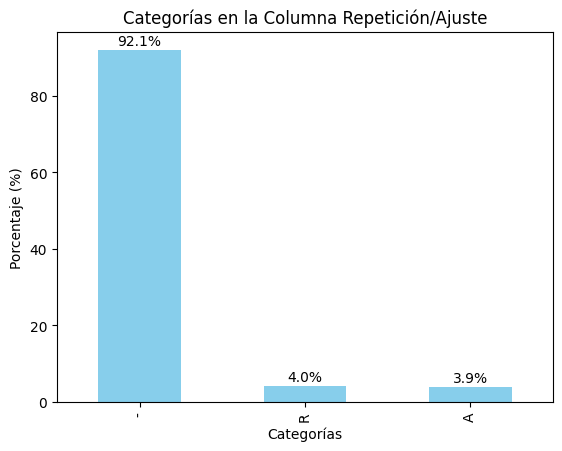

In [239]:
# Agrupar los datos por 'ID' y tomar la primera aparición de cada trabajo
df_unique = df.groupby('Nº').first()

# Contar la frecuencia de las categorías en la columna "Repetición/Ajuste" para trabajos únicos
category_counts = df_unique["Repetición|Ajuste"].value_counts()

# Calcular el porcentaje para cada categoría
category_percentages = (category_counts / category_counts.sum()) * 100

# Crear el gráfico de barras
fig, ax = plt.subplots()
category_percentages.plot(kind='bar', ax=ax, color='skyblue')

# Añadir títulos y etiquetas
ax.set_title('Categorías en la Columna Repetición/Ajuste')
ax.set_xlabel('Categorías')
ax.set_ylabel('Porcentaje (%)')

# Añadir etiquetas de porcentaje encima de cada barra
for i, v in enumerate(category_percentages):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# Mostrar el gráfico
plt.show()


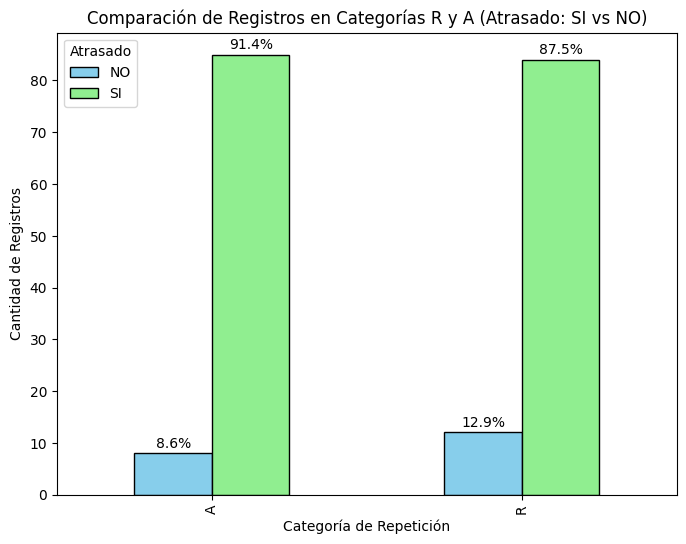

In [240]:
# Agrupar los datos por 'ID' y tomar la primera aparición de cada trabajo
df_unique = df.groupby('Nº').first()

# Filtrar solo las categorías 'R' y 'A' en la columna "Repetición|Ajuste" para trabajos únicos
df_filtered = df_unique[df_unique["Repetición|Ajuste"].isin(["R", "A"])]

# Contar la cantidad de registros donde "Atrasado" es "SI" y "NO" para cada categoría de "Repetición"
category_counts = df_filtered.groupby(["Repetición|Ajuste", "Atrasado"]).size().unstack(fill_value=0)

# Calcular los porcentajes para cada categoría de "Repetición" y "Atrasado"
category_percentages = (category_counts.T / category_counts.T.sum()).T * 100

# Crear el gráfico de barras agrupado para comparar
fig, ax = plt.subplots(figsize=(8, 6))
category_counts.plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen'], edgecolor='black')

# Añadir títulos y etiquetas
ax.set_title('Comparación de Registros en Categorías R y A (Atrasado: SI vs NO)')
ax.set_xlabel('Categoría de Repetición')
ax.set_ylabel('Cantidad de Registros')

# Añadir leyenda
ax.legend(title='Atrasado')

# Añadir etiquetas de porcentaje encima de cada barra
for p in ax.patches:
    # Obtener la altura de la barra
    height = p.get_height()
    # Calcular el porcentaje de esa barra en relación con el total
    total = category_counts.sum(axis=1)[int(p.get_x() + p.get_width()/2)]
    percentage = (height / total) * 100
    # Añadir el porcentaje encima de la barra
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{percentage:.1f}%', ha='center', va='bottom')

# Mostrar el gráfico
plt.show()


### Empleados

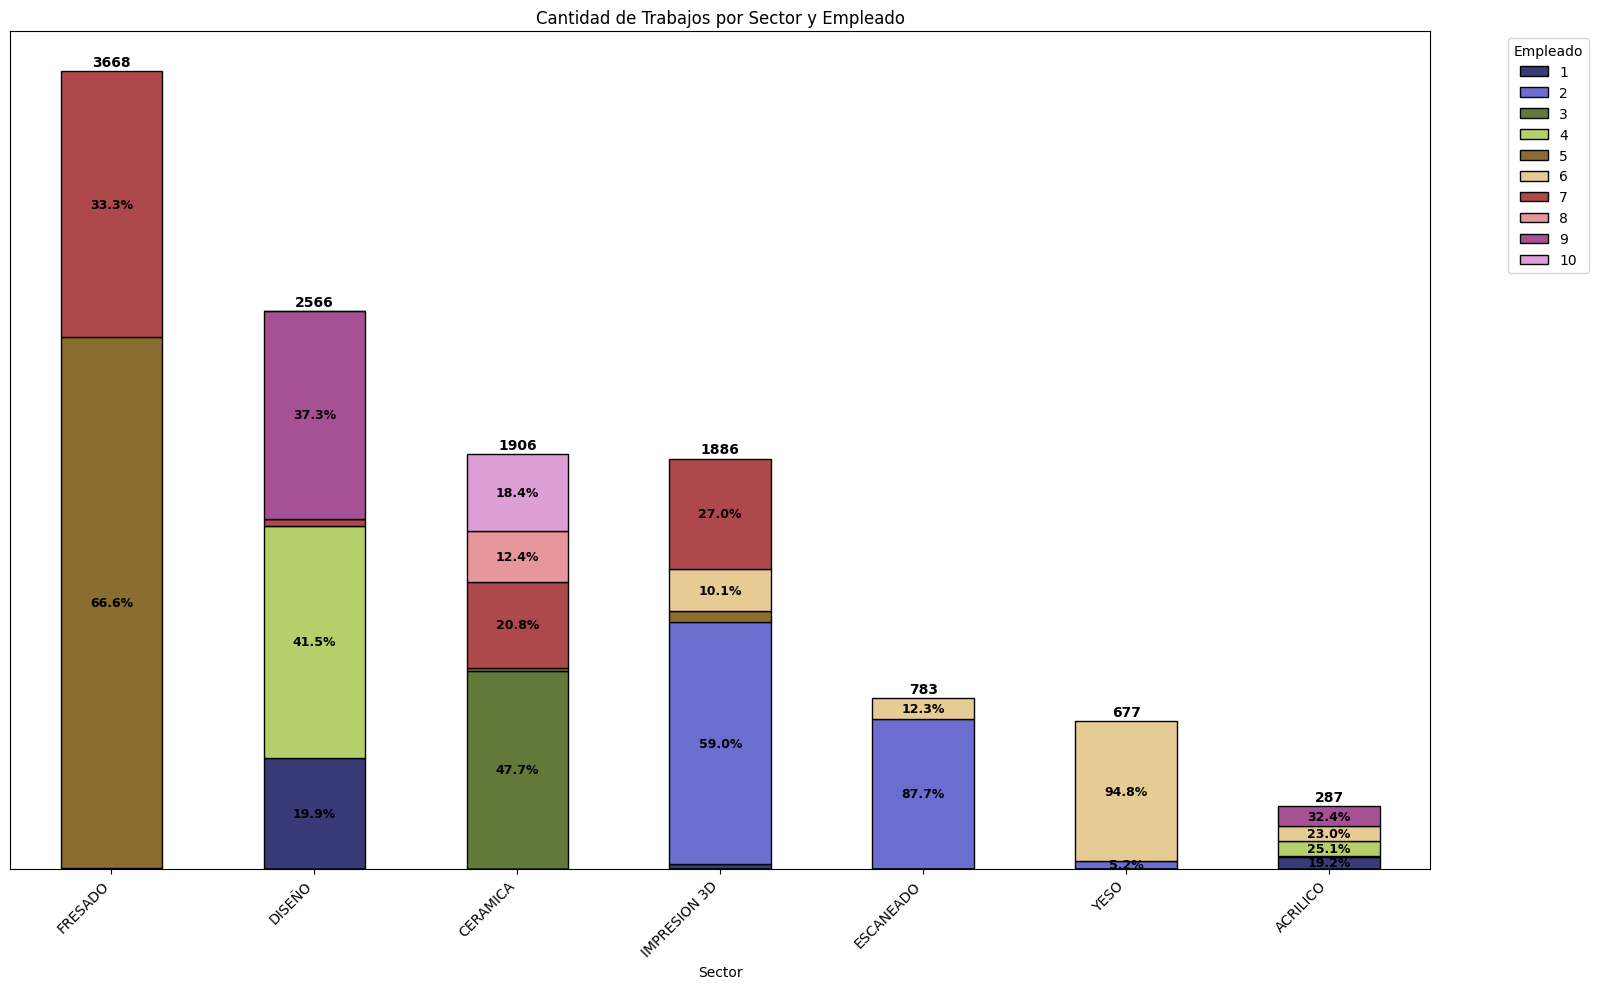

In [241]:
# Cantidad de Trabajos por Sector y Empleado

# Agrupar por sector y empleado, y contar la cantidad de trabajos
employee_sector_counts = df.groupby(['Sector', 'Empleado'])['Nº'].count().unstack(fill_value=0)

# Calcular la suma total de trabajos por sector
sector_totals = employee_sector_counts.sum(axis=1)

# Ordenar los sectores por la suma total de trabajos en orden descendente
sorted_sectors = sector_totals.sort_values(ascending=False).index

# Reordenar el DataFrame de acuerdo con los sectores ordenados
employee_sector_counts = employee_sector_counts.loc[sorted_sectors]

# Crear el gráfico de barras apilado
fig, ax = plt.subplots(figsize=(16, 10))

# Crear las barras apiladas
employee_sector_counts.plot(kind='bar', stacked=True, ax=ax, colormap='tab20b', edgecolor='k')

# Añadir títulos y etiquetas
ax.set_title('Cantidad de Trabajos por Sector y Empleado')
ax.set_xlabel('Sector')
ax.set_ylabel('Cantidad de Trabajos')

# Añadir etiquetas con la cantidad total de trabajos y porcentajes
for i, sector in enumerate(sorted_sectors):
    total = sector_totals[sector]
    ax.text(i, total + 10, str(total), ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Calcular porcentajes por empleado
    bottom = 0
    for emp in employee_sector_counts.columns:
        if employee_sector_counts.loc[sector, emp] > 0:
            segment_height = employee_sector_counts.loc[sector, emp]
            percentage = (segment_height / total) * 100

            # Verificar si el espacio es suficiente para mostrar el porcentaje y si el sector no es "metal"
            if sector != "METAL" and segment_height > total * 0.05:  # Ajusta este umbral según sea necesario
                ax.text(i, bottom + segment_height / 2, f'{percentage:.1f}%', 
                        ha='center', va='center', fontsize=9, color='black', fontweight='bold')
            bottom += segment_height

# Ocultar el eje y
ax.yaxis.set_visible(False)

# Añadir leyenda
ax.legend(title='Empleado', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar el diseño para que las etiquetas no se solapen
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [242]:
# # Filtramos solo los trabajos atrasados
# df_atrasados = df[df['Atrasado'] == "SI"]

# # Calculamos el total de trabajos por sector
# total_trabajos_sector = df.groupby('Sector').size().reset_index(name='Total')

# # Contamos la cantidad de trabajos atrasados por empleado y sector
# trabajos_atrasados = df_atrasados.groupby(['Sector', 'Empleado']).size().reset_index(name='Cantidad')

# # Unimos los datos para calcular el porcentaje
# trabajos_atrasados = trabajos_atrasados.merge(total_trabajos_sector, on='Sector')
# trabajos_atrasados['Porcentaje'] = (trabajos_atrasados['Cantidad'] / trabajos_atrasados['Total']) * 100

# # Filtramos solo los empleados con registros de trabajos atrasados
# trabajos_atrasados = trabajos_atrasados[trabajos_atrasados['Cantidad'] > 0]

# # Ordenamos las columnas de forma descendente según el porcentaje para cada sector
# trabajos_atrasados = trabajos_atrasados.sort_values(by=['Sector', 'Porcentaje'], ascending=[True, False])

# # Función para obtener el orden de empleados según el porcentaje (descendente) para cada subconjunto
# def ordenar_empleados(sub_df):
#     return sub_df.sort_values(by="Porcentaje", ascending=False)['Empleado']

# # Creamos gráficos separados por sector, asegurando que los valores del eje x aparezcan
# g = sns.FacetGrid(trabajos_atrasados, col="Sector", col_wrap=3, height=4, sharex=False, sharey=False)

# # Pasamos el orden de empleados a cada sector usando map_dataframe y aplicando la ordenación en cada subconjunto
# g.map_dataframe(lambda data, **kwargs: sns.barplot(
#     x='Empleado', y='Porcentaje', data=data, 
#     order=ordenar_empleados(data), **kwargs))

# # Personalizamos los gráficos
# g.set_titles("Sector: {col_name}")
# g.set_axis_labels("Empleado", "Porcentaje de trabajos atrasados")
# g.fig.suptitle('Porcentaje de trabajos atrasados por empleado y sector', y=1.05)

# # Mostramos los valores del eje x en todos los gráficos y rotamos las etiquetas
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotamos las etiquetas del eje X para mejorar la legibilidad

# plt.show()


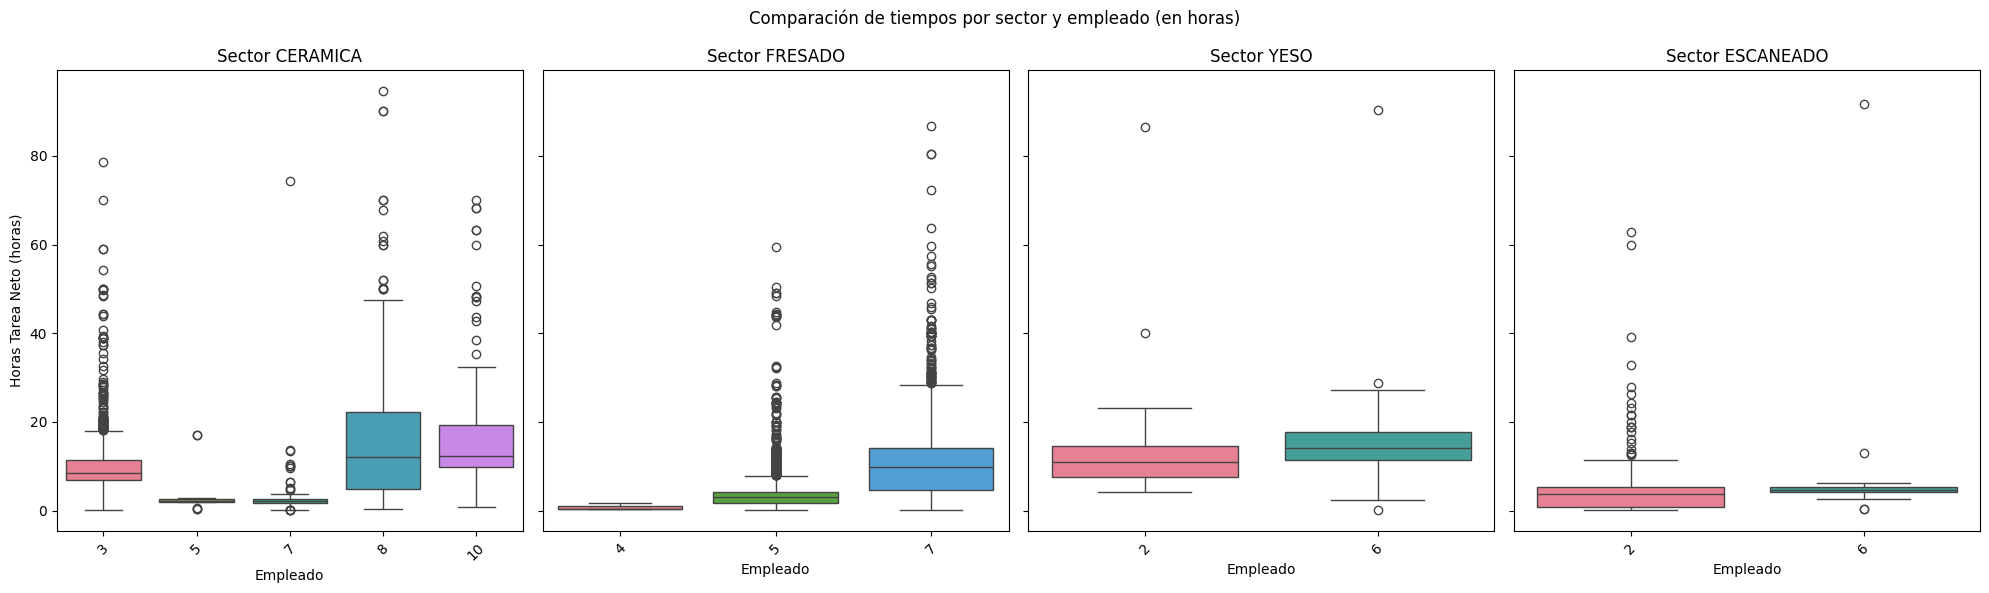

In [243]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Suponiendo que df ya está definido y contiene la columna 'Sector'
# Filtrar los sectores deseados
sectores_deseados = ['YESO', 'CERAMICA', 'FRESADO',"ESCANEADO"]
df_filtrado = df[df['Sector'].isin(sectores_deseados)]

# Convertir el tiempo en formato HH:MM a horas decimales
def convertir_a_horas(tiempo_horas):
    h, m = map(int, tiempo_horas.split(':'))
    return h + m / 60  # Convertir minutos a fracción de hora

df_filtrado['Horas Tarea Neto (horas)'] = df_filtrado['Horas Tarea Neto'].apply(convertir_a_horas)

# Obtener la lista de sectores únicos en trabajos atrasados después del filtro
sectores_unicos = df_filtrado['Sector'].unique()

# Configurar el tamaño de la figura y los subplots
num_sectores = len(sectores_unicos)
fig, axes = plt.subplots(nrows=1, ncols=num_sectores, figsize=(5 * num_sectores, 6), sharey=True)

# Si solo hay un sector, convertir axes en una lista para manejarlo uniformemente
if num_sectores == 1:
    axes = [axes]

# Crear un gráfico para cada sector
for i, sector in enumerate(sectores_unicos):
    df_sector = df_filtrado[df_filtrado['Sector'] == sector]
    
    # Generar una paleta de colores única para los empleados de este sector
    empleados_unicos = df_sector['Empleado'].unique()
    paleta_colores = sns.color_palette("husl", len(empleados_unicos))
    
    # Crear el boxplot en el subplot correspondiente con colores personalizados
    sns.boxplot(x='Empleado', y='Horas Tarea Neto (horas)', data=df_sector, ax=axes[i], palette=paleta_colores)
    
    # Personalizar el gráfico
    axes[i].set_title(f'Sector {sector}')
    axes[i].set_xlabel('Empleado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotar etiquetas si es necesario

# Ajustar la figura
fig.suptitle('Comparación de tiempos por sector y empleado (en horas)')
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Ajustar el espacio para el título

# Mostrar la figura completa
plt.show()



In [244]:
# ANOVA tiempo horas entre empleados

# Convertir el tiempo en formato HH:MM a horas decimales
def convertir_a_horas(tiempo_horas):
    h, m = map(int, tiempo_horas.split(':'))
    return h + m / 60  # Convertir minutos a fracción de hora

df['Horas Tarea Neto (horas)'] = df['Horas Tarea Neto'].apply(convertir_a_horas)

# Obtener la lista de sectores únicos
sectores_unicos = df['Sector'].unique()

# Realizar ANOVA para cada sector
resultados_anova = {}

for sector in sectores_unicos:
    df_sector = df[df['Sector'] == sector]
    
    # Agrupar por empleado y extraer los tiempos en una lista por empleado
    grupos = df_sector.groupby('Empleado')['Horas Tarea Neto (horas)'].apply(list)
    
    # Realizar ANOVA si hay más de un grupo
    if len(grupos) > 1:
        anova_resultado = stats.f_oneway(*grupos)
        resultados_anova[sector] = {
            'Estadístico F': anova_resultado.statistic,
            'Valor p': anova_resultado.pvalue
        }
    else:
        resultados_anova[sector] = {
            'Estadístico F': None,
            'Valor p': None,
            'Mensaje': 'No hay suficientes grupos para ANOVA'
        }

# Mostrar resultados
for sector, resultado in resultados_anova.items():
    print(f'\nSector: {sector}')
    if resultado['Estadístico F'] is not None:
        print(f'Estadístico F: {resultado["Estadístico F"]}')
        print(f'Valor p: {resultado["Valor p"]}')
        if resultado['Valor p'] < 0.05:
            print("Hay diferencias significativas en los tiempos entre los empleados.")
        else:
            print("No hay diferencias significativas en los tiempos entre los empleados.")
    else:
        print(resultado['Mensaje'])



Sector: IMPRESION 3D
Estadístico F: 2.1748157566577957
Valor p: 0.06950708143991072
No hay diferencias significativas en los tiempos entre los empleados.

Sector: DISEÑO
Estadístico F: 2.913512409527282
Valor p: 0.012546592795090687
Hay diferencias significativas en los tiempos entre los empleados.

Sector: ACRILICO
Estadístico F: 3.342287239635591
Valor p: 0.010760081551851925
Hay diferencias significativas en los tiempos entre los empleados.

Sector: CERAMICA
Estadístico F: 124.88556353736044
Valor p: 9.702094474923108e-95
Hay diferencias significativas en los tiempos entre los empleados.

Sector: FRESADO
Estadístico F: 452.7755455131446
Valor p: 1.8757097983785872e-176
Hay diferencias significativas en los tiempos entre los empleados.

Sector: YESO
Estadístico F: 0.2003166138712852
Valor p: 0.6546090000073062
No hay diferencias significativas en los tiempos entre los empleados.

Sector: ESCANEADO
Estadístico F: 6.944119786169847
Valor p: 0.008576250919113862
Hay diferencias signifi

### sector

### tipo de servicio

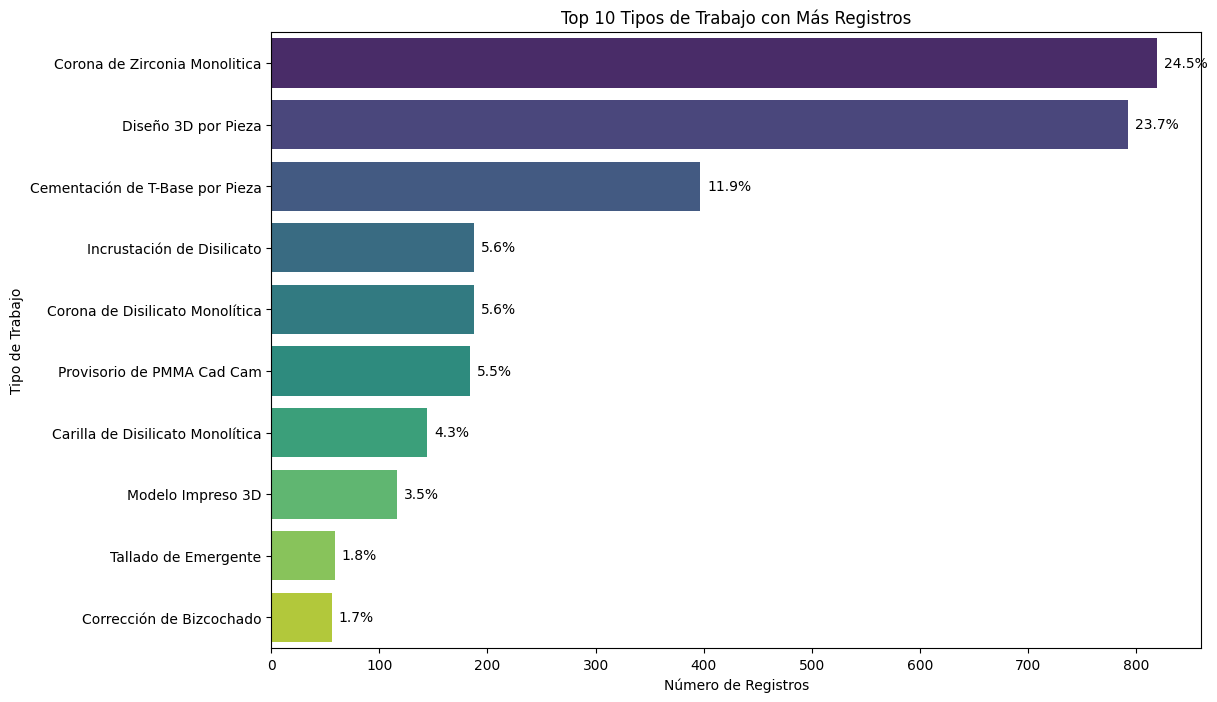

In [245]:
# top 10 tipo de servicio

# Contar el número de trabajos por tipo de trabajo (usando el ID para asegurar que se cuenten registros únicos)
conteo_trabajos = df.groupby('Servicio')['Nº'].nunique().reset_index(name='Conteo')

# Obtener los 10 tipos de trabajo con más registros
top_10_trabajos = conteo_trabajos.sort_values(by='Conteo', ascending=False).head(10)

# Calcular el porcentaje del total de todos los registros (no solo de los top 10)
total_registros = conteo_trabajos['Conteo'].sum()
top_10_trabajos['Porcentaje'] = (top_10_trabajos['Conteo'] / total_registros) * 100

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Conteo', y='Servicio', data=top_10_trabajos, palette='viridis')

# Añadir títulos y etiquetas
plt.title('Top 10 Tipos de Trabajo con Más Registros')
plt.xlabel('Número de Registros')
plt.ylabel('Tipo de Trabajo')

# Añadir porcentaje en cada barra (sobre el total de todos los registros)
for p in ax.patches:
    width = p.get_width()
    percentage = (width / total_registros) * 100
    ax.annotate(f'{percentage:.1f}%', (width, p.get_y() + p.get_height() / 2),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Mostrar el gráfico
plt.show()



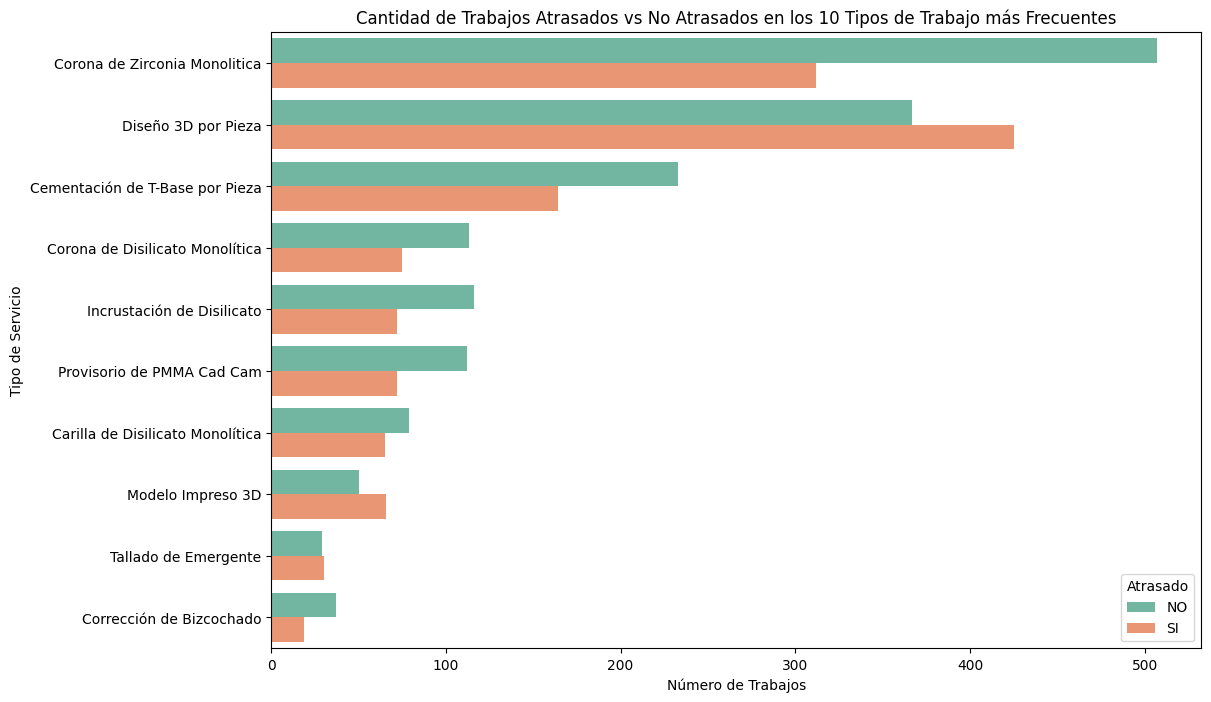

In [270]:
# Cantidad de Trabajos Atrasados vs No Atrasados

# Contar el número de trabajos por tipo de trabajo y estado de atraso (usando el ID para asegurar registros únicos)
conteo_trabajos = df.groupby(['Servicio', 'Atrasado'])['Nº'].nunique().reset_index(name='Conteo')

# Obtener los 10 tipos de trabajo con más registros en total
top_10_trabajos = conteo_trabajos.groupby('Servicio')['Conteo'].sum().nlargest(10).index

# Filtrar los datos para los 10 tipos de trabajo más frecuentes
top_10_con_atraso = conteo_trabajos[conteo_trabajos['Servicio'].isin(top_10_trabajos)]

# Ordenar los datos de manera descendente por el total de trabajos (sumando atrasados y no atrasados)
orden_total = top_10_con_atraso.groupby('Servicio')['Conteo'].sum().sort_values(ascending=False).index
top_10_con_atraso['Servicio'] = pd.Categorical(top_10_con_atraso['Servicio'], categories=orden_total, ordered=True)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Conteo', y='Servicio', hue='Atrasado', data=top_10_con_atraso, palette='Set2')

# Añadir títulos y etiquetas
plt.title('Cantidad de Trabajos Atrasados vs No Atrasados en los 10 Tipos de Trabajo más Frecuentes')
plt.xlabel('Número de Trabajos')
plt.ylabel('Tipo de Servicio')

# Mostrar el gráfico
plt.show()



In [247]:
# Estadístico Chi-cuadrado: retraso y el tipo de servicio

# Crear la tabla de contingencia entre 'Tipo de Servicio' y 'Atrasado'
tabla_contingencia = pd.crosstab(df['Servicio'], df['Atrasado'])

# Realizar la prueba de Chi-cuadrado
chi2, p, dof, expected = stats.chi2_contingency(tabla_contingencia)

# Mostrar los resultados
print(f'Estadístico Chi-cuadrado: {chi2:.4f}')
print(f'Valor p: {p:.4f}')
print(f'Grados de libertad: {dof}')
print('Frecuencias esperadas:')
print(expected)

# Interpretación del valor p
alpha = 0.05
if p < alpha:
    print("Existe una relación estadísticamente significativa entre el retraso y el tipo de servicio.")
else:
    print("No hay una relación estadísticamente significativa entre el retraso y el tipo de servicio.")


Estadístico Chi-cuadrado: 362.7882
Valor p: 0.0000
Grados de libertad: 44
Frecuencias esperadas:
[[7.13216682e+00 5.86783318e+00]
 [1.04239361e+01 8.57606387e+00]
 [1.48129619e+01 1.21870381e+01]
 [3.29176930e+00 2.70823070e+00]
 [3.84039752e+02 3.15960248e+02]
 [7.68079504e+00 6.31920496e+00]
 [1.64588465e+00 1.35411535e+00]
 [1.15211926e+01 9.47880744e+00]
 [2.17805402e+02 1.79194598e+02]
 [4.95411280e+02 4.07588720e+02]
 [1.31670772e+01 1.08329228e+01]
 [2.57800399e+03 2.12099601e+03]
 [3.07231802e+01 2.52768198e+01]
 [2.57855262e+01 2.12144738e+01]
 [1.59102183e+01 1.30897817e+01]
 [1.24264291e+03 1.02235709e+03]
 [5.48628217e-01 4.51371783e-01]
 [4.16957445e+01 3.43042555e+01]
 [3.29176930e+00 2.70823070e+00]
 [5.48628217e-01 4.51371783e-01]
 [1.97506158e+01 1.62493842e+01]
 [1.97506158e+01 1.62493842e+01]
 [2.79800391e+01 2.30199609e+01]
 [5.48628217e-01 4.51371783e-01]
 [4.97605793e+02 4.09394207e+02]
 [6.03491039e+00 4.96508961e+00]
 [5.15710524e+01 4.24289476e+01]
 [1.20698208

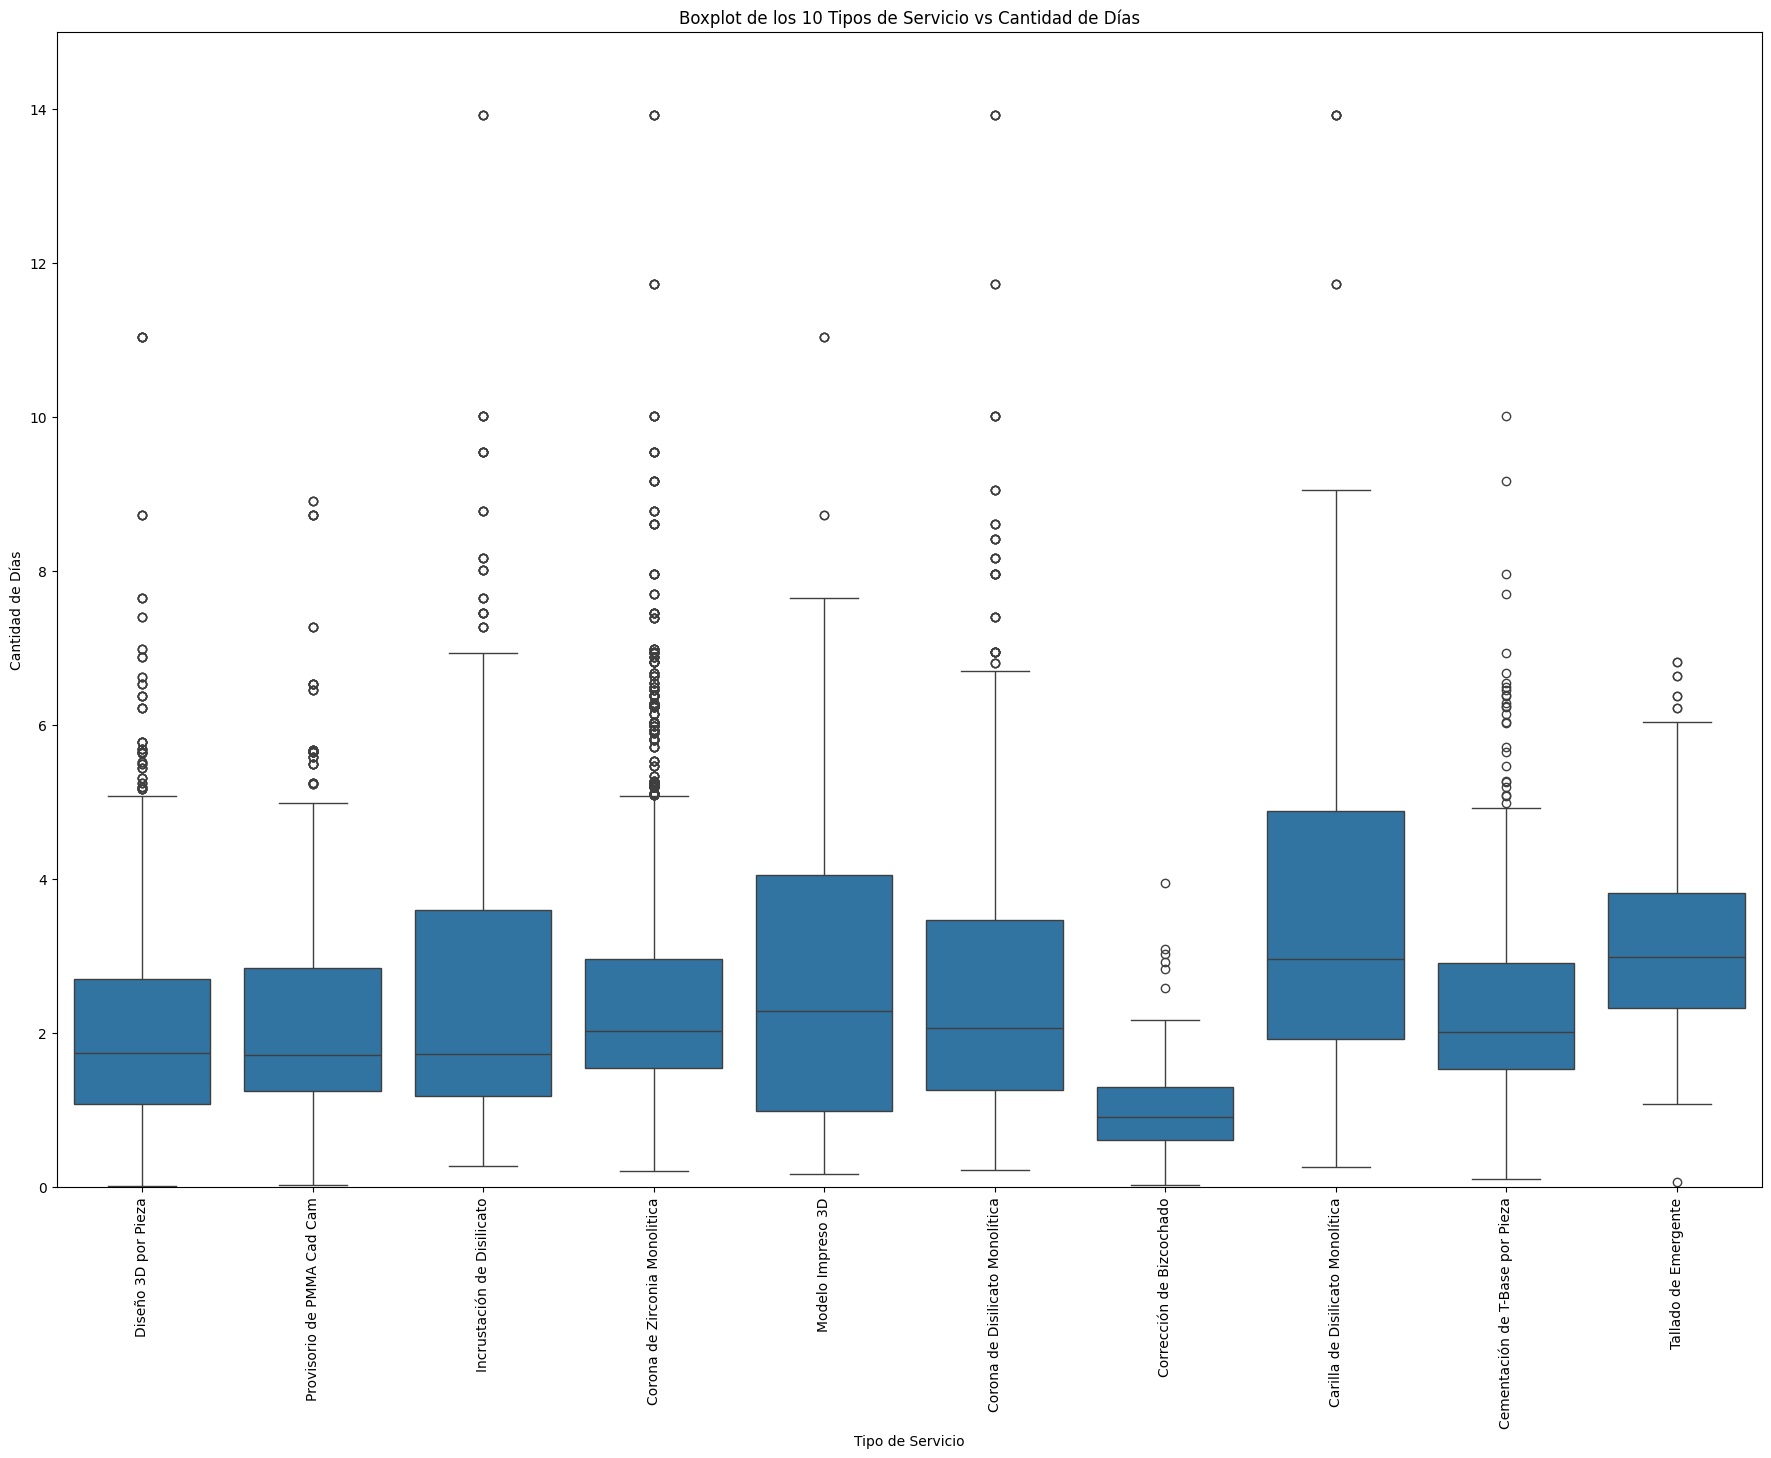

In [248]:
# Boxplot Tipos de Servicio vs Cantidad de Días

# Contar los trabajos por tipo de servicio
conteo_trabajos = df.groupby('Servicio')['Nº'].nunique().reset_index(name='Conteo')

# Obtener los 10 tipos de servicio con más registros
top_10_servicios = conteo_trabajos.sort_values(by='Conteo', ascending=False).head(10)['Servicio']

# Filtrar el DataFrame para solo los 10 tipos de servicio más frecuentes
df_top_10 = df[df['Servicio'].isin(top_10_servicios)]

# Crear la figura
plt.figure(figsize=(22, 15))

# Crear el boxplot para los 10 servicios más frecuentes
sns.boxplot(x='Servicio', y='Días Pedido Neto', data=df_top_10)

# Añadir título y etiquetas
plt.title('Boxplot de los 10 Tipos de Servicio vs Cantidad de Días')
plt.xlabel('Tipo de Servicio')
plt.ylabel('Cantidad de Días')

# Rotar etiquetas del eje x si son muy largas
plt.xticks(rotation=90)

# Establecer el límite del eje y hasta 15
plt.ylim(0, 15)

# Mostrar el gráfico
plt.show()



In [249]:
# ANOVA: cantidad de días vs tipos de servicio.

# Filtrar el DataFrame para los 10 tipos de servicio más frecuentes
df_top_10 = df[df['Servicio'].isin(top_10_servicios)]

# Realizar la prueba ANOVA
anova_result = stats.f_oneway(
    *[df_top_10[df_top_10['Servicio'] == servicio]['Días Pedido Neto'] for servicio in top_10_servicios]
)

# Mostrar los resultados
print(f'Estadístico F: {anova_result.statistic:.4f}')
print(f'Valor p: {anova_result.pvalue:.4f}')

# Interpretación del valor p
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Existen diferencias significativas en la cantidad de días de pedido neto entre los tipos de servicio.")
else:
    print("No existen diferencias significativas en la cantidad de días de pedido neto entre los tipos de servicio.")


Estadístico F: 59.3249
Valor p: 0.0000
Existen diferencias significativas en la cantidad de días de pedido neto entre los tipos de servicio.


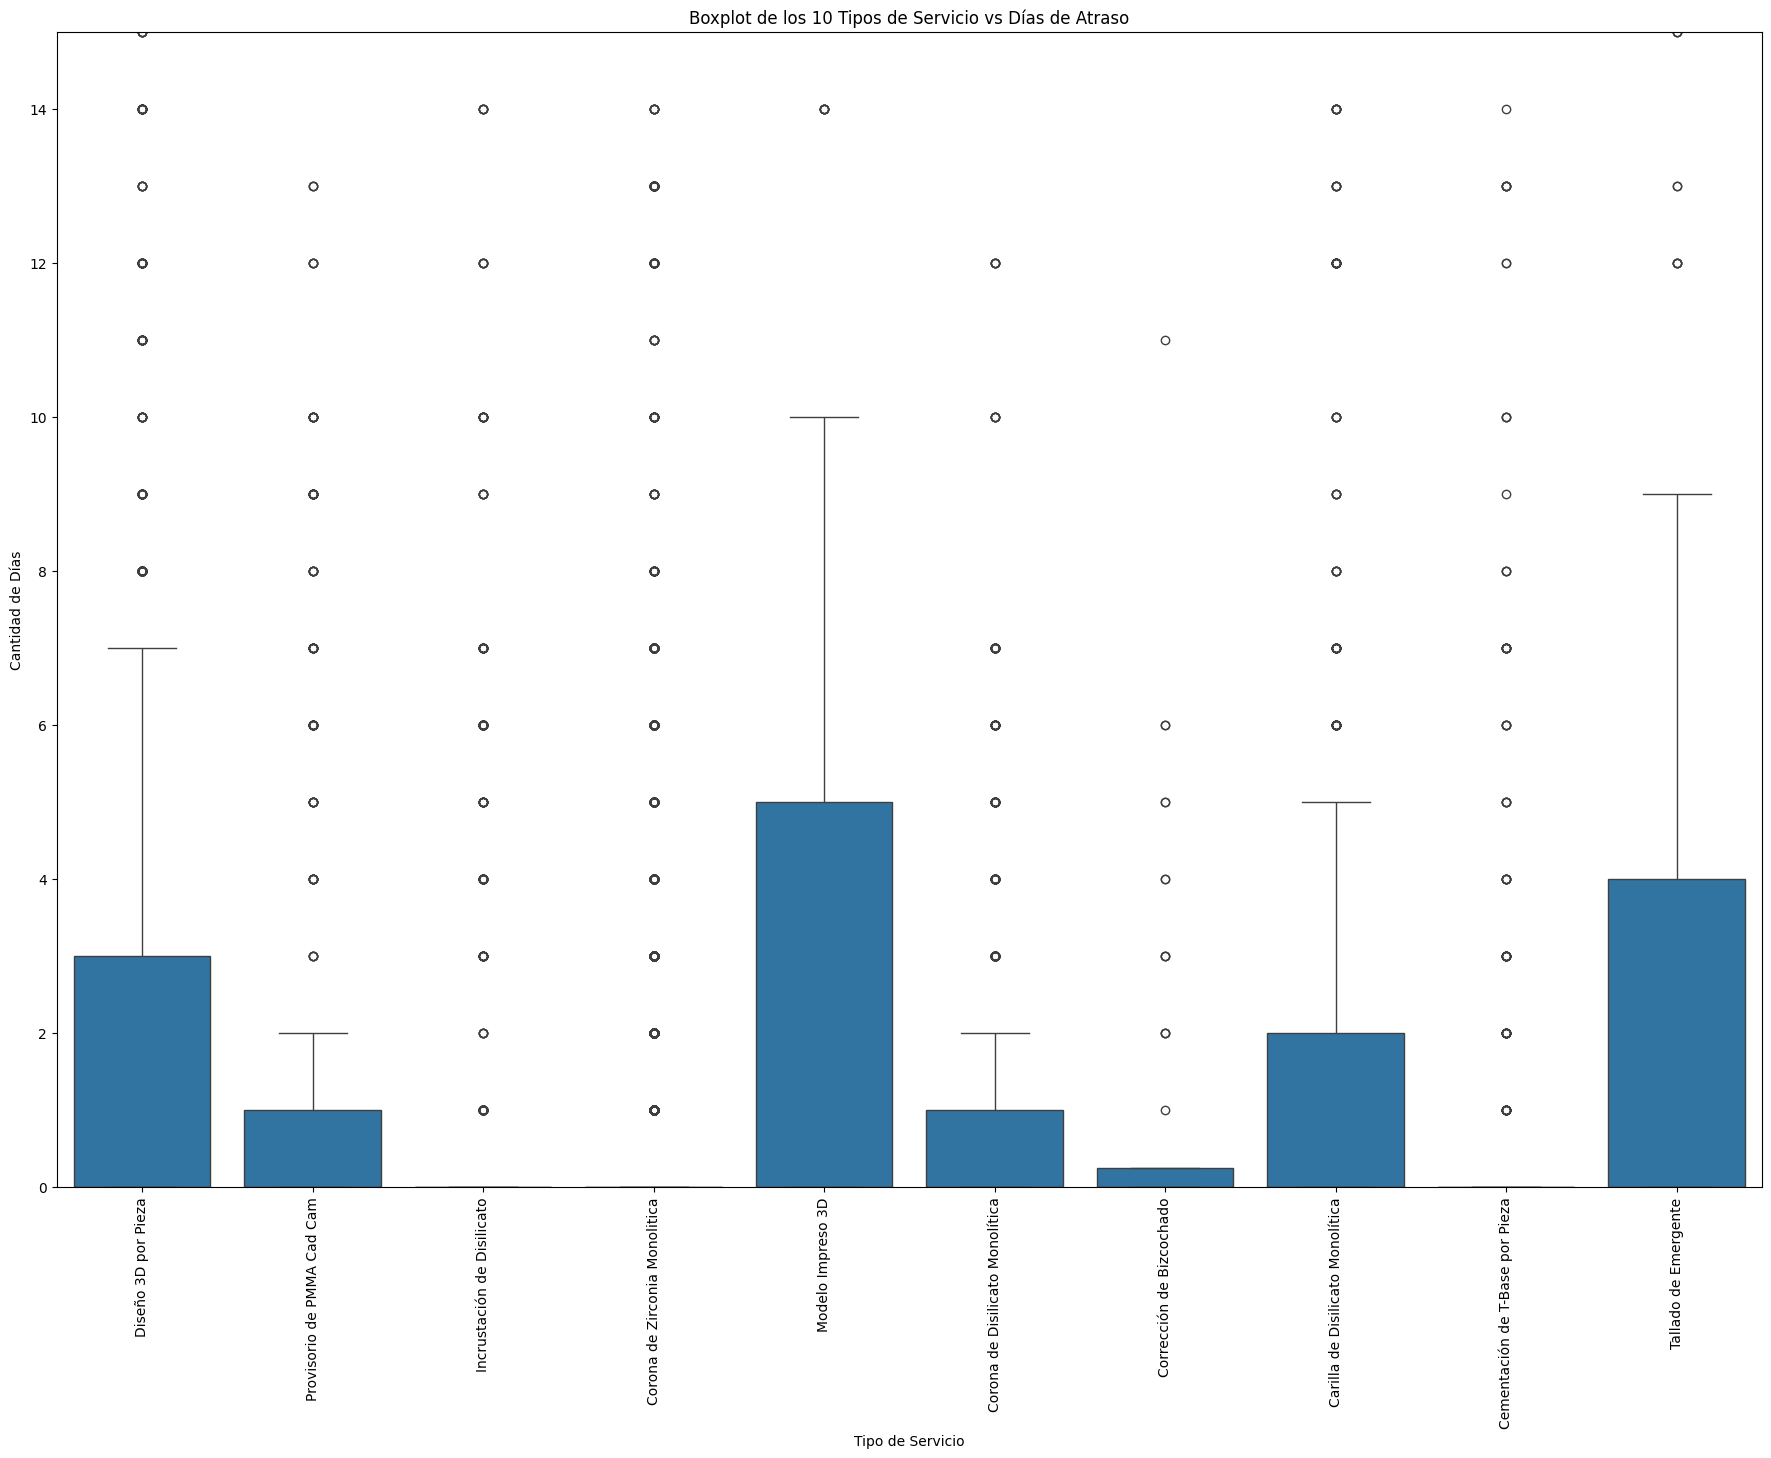

In [250]:
#Boxplot tipo de Servicio vs Días de Atraso

# Contar los trabajos por tipo de servicio
conteo_trabajos = df.groupby('Servicio')['Nº'].nunique().reset_index(name='Conteo')

# Obtener los 10 tipos de servicio con más registros
top_10_servicios = conteo_trabajos.sort_values(by='Conteo', ascending=False).head(10)['Servicio']

# Filtrar el DataFrame para solo los 10 tipos de servicio más frecuentes
df_top_10 = df[df['Servicio'].isin(top_10_servicios)]

# Crear la figura
plt.figure(figsize=(22, 15))

# Crear el boxplot para los 10 servicios más frecuentes
sns.boxplot(x='Servicio', y='Días de Atraso', data=df_top_10)

# Añadir título y etiquetas
plt.title('Boxplot de los 10 Tipos de Servicio vs Días de Atraso')
plt.xlabel('Tipo de Servicio')
plt.ylabel('Cantidad de Días')

# Rotar etiquetas del eje x si son muy largas
plt.xticks(rotation=90)

# Establecer el límite del eje y hasta 15
plt.ylim(0, 15)

# Mostrar el gráfico
plt.show()


In [251]:
# ANOVA: cantidad de días de atraso vs tipos de servicio

# Filtrar el DataFrame para los 10 tipos de servicio más frecuentes
df_top_10 = df[df['Servicio'].isin(top_10_servicios)]

# Realizar la prueba ANOVA
anova_result = stats.f_oneway(
    *[df_top_10[df_top_10['Servicio'] == servicio]['Días de Atraso'] for servicio in top_10_servicios]
)

# Mostrar los resultados
print(f'Estadístico F: {anova_result.statistic:.4f}')
print(f'Valor p: {anova_result.pvalue:.4f}')

# Interpretación del valor p
alpha = 0.05
if anova_result.pvalue < alpha:
    print("Existen diferencias significativas en la cantidad de días de pedido neto entre los tipos de servicio.")
else:
    print("No existen diferencias significativas en la cantidad de días de pedido neto entre los tipos de servicio.")

Estadístico F: 20.3316
Valor p: 0.0000
Existen diferencias significativas en la cantidad de días de pedido neto entre los tipos de servicio.


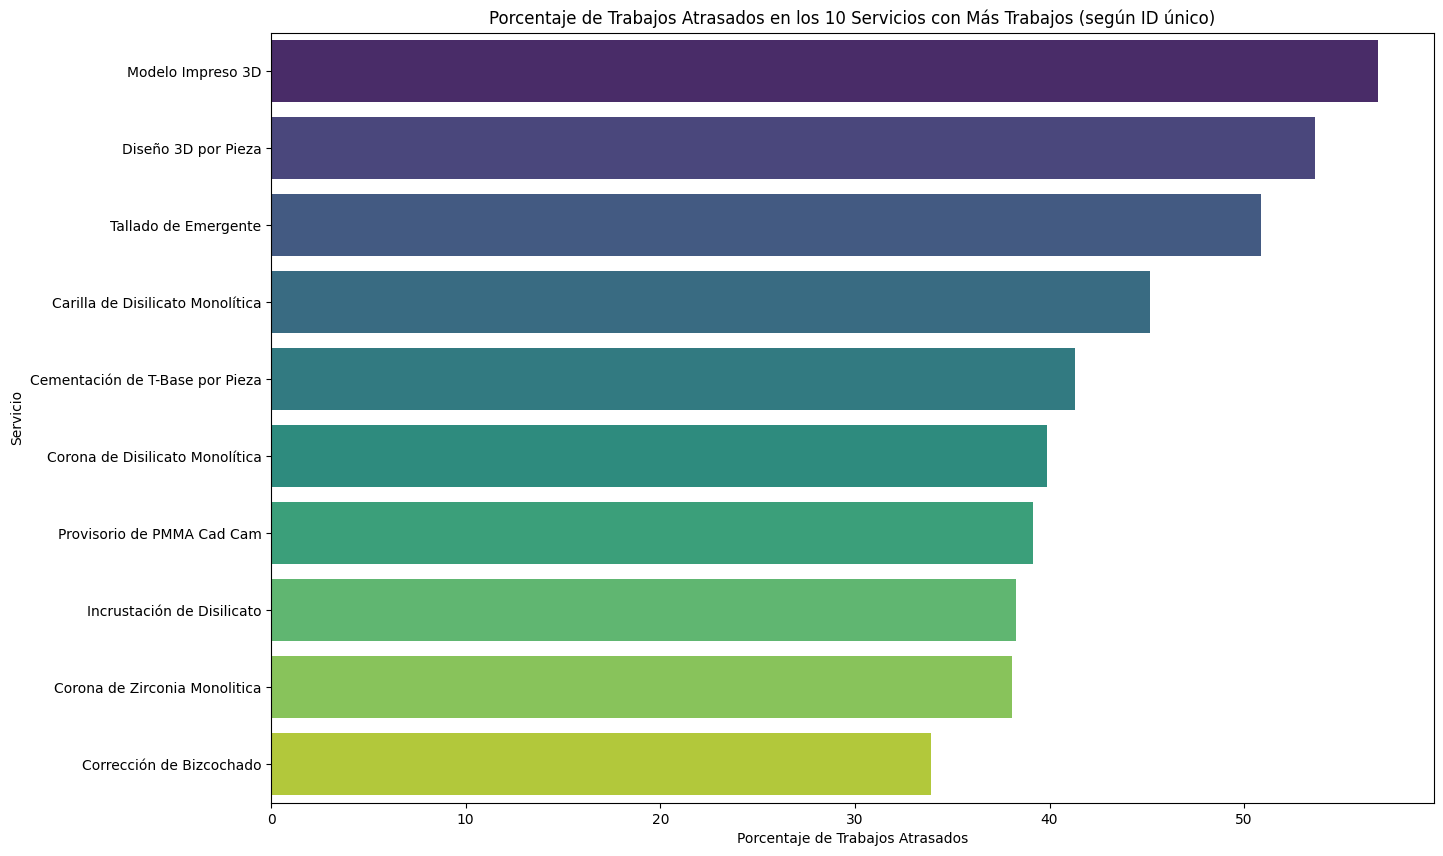

In [252]:
# Porcentaje de Trabajos Atrasados en los Servicios con Más Trabajos

# Filtrar solo los trabajos atrasados
df_atrasados = df[df['Atrasado'] == "SI"]

# Calcular la cantidad de trabajos atrasados por sector basados en el ID único
trabajos_atrasados_por_sector = df_atrasados.groupby('Servicio')['Nº'].nunique().reset_index(name='Cantidad Atrasados')

# Calcular el total de trabajos por sector basados en el ID único
total_trabajos_por_sector = df.groupby('Servicio')['Nº'].nunique().reset_index(name='Total Trabajos')

# Unir los datos para obtener una visión completa
sector_resumen = trabajos_atrasados_por_sector.merge(total_trabajos_por_sector, on='Servicio')
sector_resumen['Porcentaje Atrasados'] = (sector_resumen['Cantidad Atrasados'] / sector_resumen['Total Trabajos']) * 100

# Ordenar los sectores de forma descendente según el total de trabajos
sector_resumen = sector_resumen.sort_values(by='Total Trabajos', ascending=False)

# Filtrar los 10 servicios con más trabajos
top_10_servicios = sector_resumen.head(10)

# Ordenar los 10 servicios por el porcentaje de trabajos atrasados de forma descendente
top_10_servicios = top_10_servicios.sort_values(by='Porcentaje Atrasados', ascending=False)

# Crear un gráfico de barras horizontales
plt.figure(figsize=(15, 10))
barplot = sns.barplot(data=top_10_servicios, y='Servicio', x='Porcentaje Atrasados', palette='viridis')

# Configurar etiquetas y título
plt.xlabel('Porcentaje de Trabajos Atrasados')
plt.ylabel('Servicio')
plt.title('Porcentaje de Trabajos Atrasados en los 10 Servicios con Más Trabajos (según ID único)')

# Mostrar el gráfico
plt.show()


### cantidad de dientes

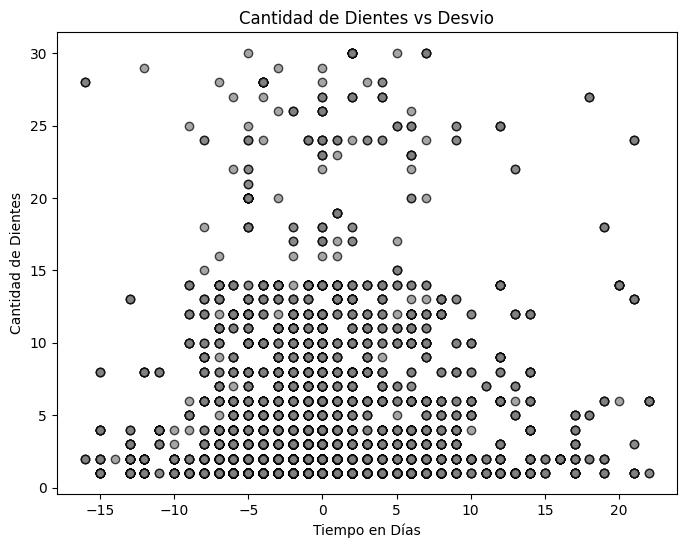

In [253]:
# Cantidad de Dientes vs Desvio

# Filtrar el DataFrame para desvio_fecha > -10
df_filtrado = df[df["desvio_fecha"] > -20]
df_filtrado = df_filtrado[df_filtrado["desvio_fecha"] < 25]

# Crear el scatter plot con el DataFrame filtrado
fig, ax = plt.subplots(figsize=(8, 6))

# Dibujar los puntos sin colores basados en "Atrasado"
scatter = ax.scatter(df_filtrado["desvio_fecha"], df_filtrado["Ctd"], color='gray', alpha=0.7, edgecolor='k')

# Añadir títulos y etiquetas
ax.set_title('Cantidad de Dientes vs Desvio')
ax.set_xlabel('Tiempo en Días')
ax.set_ylabel('Cantidad de Dientes')

# Mostrar el gráfico
plt.show()

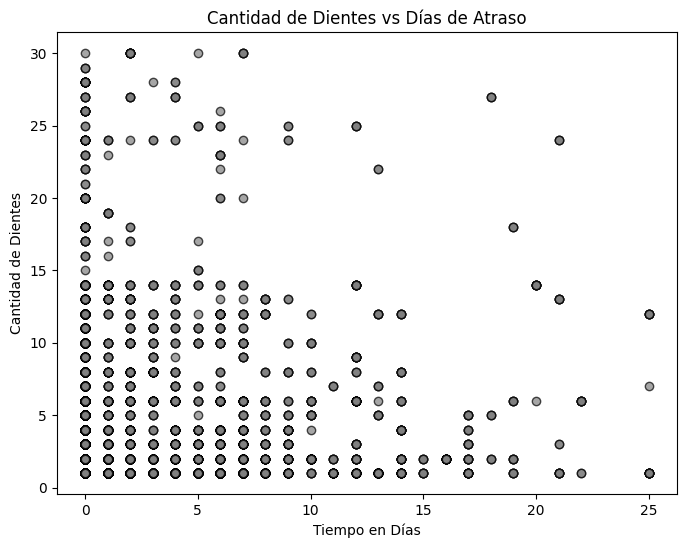

In [254]:
# Cantidad de Dientes vs Días de Atraso

# Crear el scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

# Dibujar los puntos sin colores basados en "Atrasado"
scatter = ax.scatter(df["Días de Atraso"], df["Ctd"], color='gray', alpha=0.7, edgecolor='k')

# Añadir títulos y etiquetas
ax.set_title('Cantidad de Dientes vs Días de Atraso')
ax.set_xlabel('Tiempo en Días')
ax.set_ylabel('Cantidad de Dientes')

# Mostrar el gráfico
plt.show()

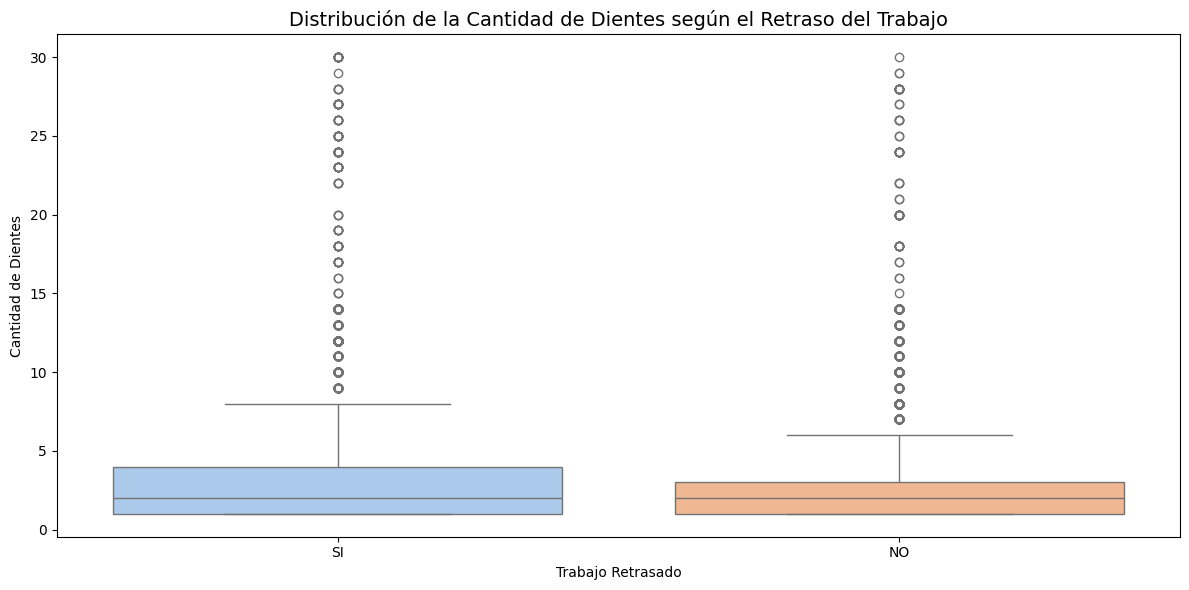

Estadístico U: 18592317.500
Valor p: 0.000
Hay una diferencia significativa entre los grupos.
Valor p para la normalidad (atrasado): 0.000
Valor p para la normalidad (no atrasado): 0.000
Valor p para la homogeneidad de varianzas: 0.000


In [255]:
# boxplot de la Cantidad de Dientes según el Retraso

# Crear un gráfico de cajas para visualizar la distribución de la cantidad de dientes
plt.figure(figsize=(12, 6))
sns.boxplot(x='Atrasado', y='Ctd', data=df, palette='pastel')

# Agregar títulos y etiquetas
plt.title("Distribución de la Cantidad de Dientes según el Retraso del Trabajo", fontsize=14)
plt.xlabel("Trabajo Retrasado")
plt.ylabel("Cantidad de Dientes")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Separar los datos en dos grupos: atrasado y no atrasado
grupo_atrasado = df[df['Atrasado'] == 'SI']['Ctd']
grupo_no_atrasado = df[df['Atrasado'] == 'NO']['Ctd']

    # Realizar la prueba de Mann-Whitney U
u_stat, p_val = stats.mannwhitneyu(grupo_atrasado, grupo_no_atrasado, alternative='two-sided')

print(f'Estadístico U: {u_stat:.3f}')
print(f'Valor p: {p_val:.3f}')

# Interpretación
alpha = 0.05
if p_val < alpha:
    print('Hay una diferencia significativa entre los grupos.')
else:
    print('No hay una diferencia significativa entre los grupos.')


# Test de normalidad
_, p_val_normalidad_atrasado = stats.shapiro(grupo_atrasado)
_, p_val_normalidad_no_atrasado = stats.shapiro(grupo_no_atrasado)

print(f'Valor p para la normalidad (atrasado): {p_val_normalidad_atrasado:.3f}')
print(f'Valor p para la normalidad (no atrasado): {p_val_normalidad_no_atrasado:.3f}')

# Test de homogeneidad de varianzas
_, p_val_varianzas = stats.levene(grupo_atrasado, grupo_no_atrasado)

print(f'Valor p para la homogeneidad de varianzas: {p_val_varianzas:.3f}')

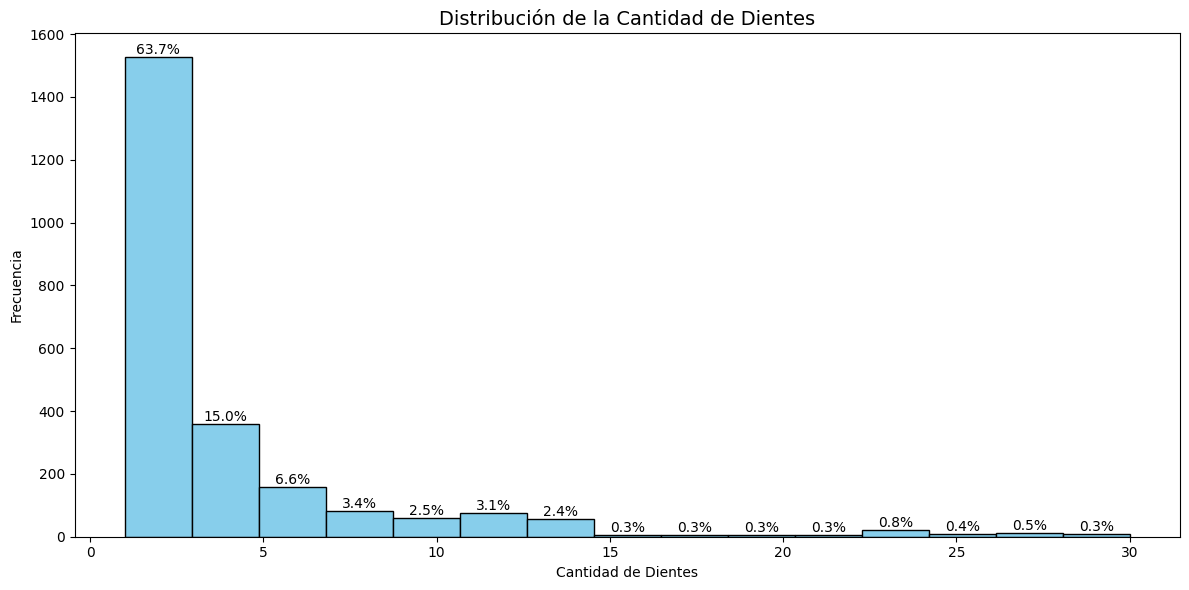

In [256]:
# Distribución de la Cantidad de Dientes

# Agrupar por 'Job_ID' y obtener una sola cantidad de dientes por ID
dientes_por_id = df.groupby('Nº')['Ctd'].first()  # O usa .mean() si quieres un promedio en lugar del primer valor

# Contar la frecuencia de cada cantidad de dientes
frecuencias = dientes_por_id.value_counts()

# Crear el histograma
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(frecuencias.index, weights=frecuencias, bins=15, color='skyblue', edgecolor='black')

# Calcular los porcentajes
total = counts.sum()
percentages = (counts / total) * 100

# Etiquetar cada barra con su porcentaje
for count, percentage, patch in zip(counts, percentages, patches):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height, f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Agregar títulos y etiquetas
plt.title("Distribución de la Cantidad de Dientes", fontsize=14)
plt.xlabel("Cantidad de Dientes")
plt.ylabel("Frecuencia")
plt.tight_layout()

# Mostrar el gráfico
plt.show()


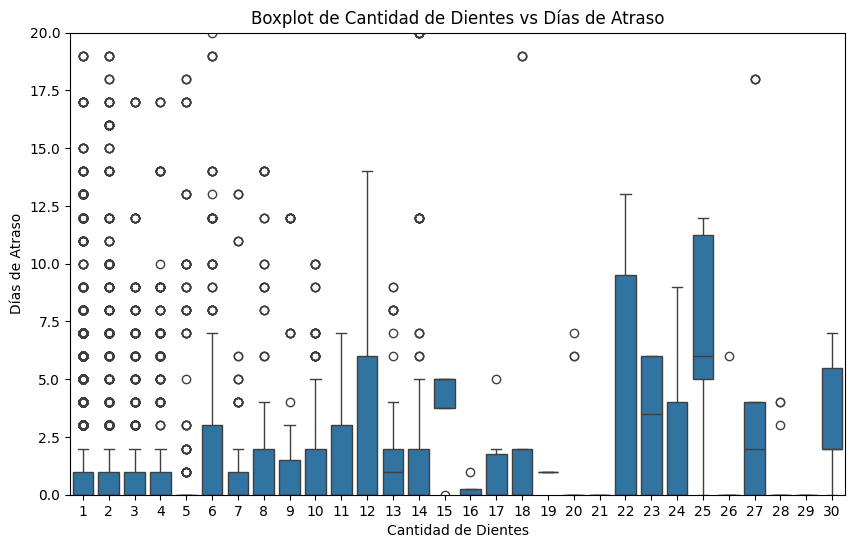

In [257]:
# Boxplot de Cantidad de Dientes vs Días de Atraso 

# Crea el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Ctd', y='Días de Atraso', data=df)

# Añade etiquetas y título
plt.xlabel('Cantidad de Dientes')
plt.ylabel('Días de Atraso')
plt.title('Boxplot de Cantidad de Dientes vs Días de Atraso')

plt.ylim(0, 20)

# Muestra el plot
plt.show()


### carga de trabajo

In [258]:
# spearman carga de trabajo y dias de atraso

# Convertir el tiempo en formato HH:MM a horas decimales
def convertir_a_horas(tiempo_horas):
    h, m = map(int, tiempo_horas.split(':'))
    return h + m / 60  # Convertir minutos a fracción de hora


# Calcular la correlación de Spearman
correlacion_spearman, p_valor_spearman = stats.spearmanr(df["Días Pedido Neto"], df["carga_trabajo_total"])

# Mostrar los resultados
print(f'Correlación de Spearman: {correlacion_spearman:.2f}')
print(f'Valor p: {p_valor_spearman:.4f}')

# Interpretar el valor p
alpha = 0.05
if p_valor_spearman < alpha:
    print("Hay una relación estadísticamente significativa entre la cantidad de dias de produccion de atraso y la carga de trabajo.")
else:
    print("No hay una relación estadísticamente significativa entre los días de atraso y la carga de trabajo.")

Correlación de Spearman: 0.06
Valor p: 0.0000
Hay una relación estadísticamente significativa entre la cantidad de dias de produccion de atraso y la carga de trabajo.


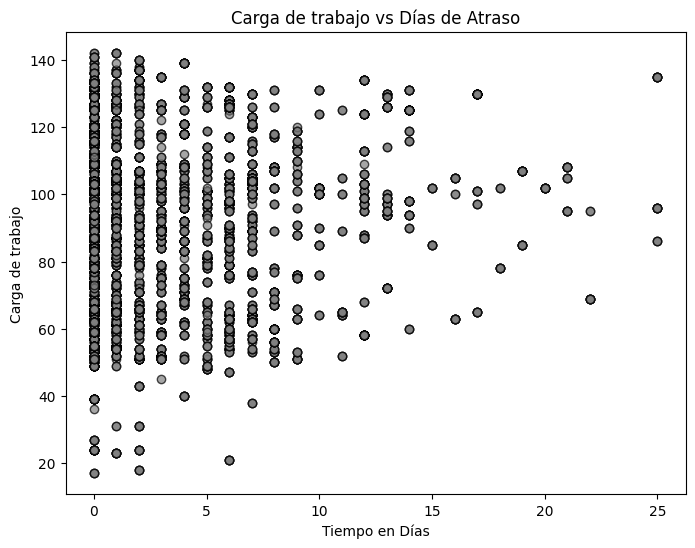

In [259]:
# Carga de trabajo vs Días de Atraso

# Filtrar los trabajos que se atrasaron
df_atrasados = df[df["Atrasado"] == "SI"]

# Crear el scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

# Dibujar los puntos sin colores basados en "Atrasado"
scatter = ax.scatter(df_atrasados["Días de Atraso"], df_atrasados["carga_trabajo_total"], color='gray', alpha=0.7, edgecolor='k')

# Añadir títulos y etiquetas
ax.set_title('Carga de trabajo vs Días de Atraso')
ax.set_xlabel('Tiempo en Días')
ax.set_ylabel('Carga de trabajo')

# Mostrar el gráfico
plt.show()

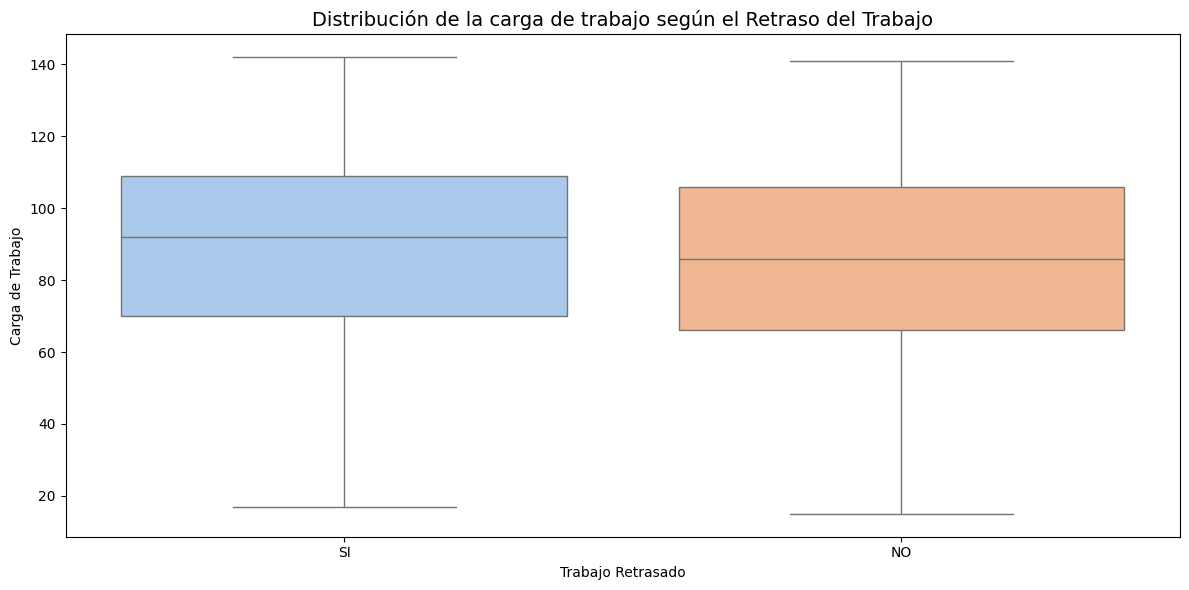

Estadístico U: 18872587.000
Valor p: 0.000
Hay una diferencia significativa entre los grupos.
Valor p para la normalidad (atrasado): 0.000
Valor p para la normalidad (no atrasado): 0.000
Valor p para la homogeneidad de varianzas: 0.875


In [260]:
# boxplot carga de trabajo vs atrasos

# Crear un gráfico de cajas para visualizar la distribución de la cantidad de dientes
plt.figure(figsize=(12, 6))
sns.boxplot(x='Atrasado', y='carga_trabajo_total', data=df, palette='pastel')

# Agregar títulos y etiquetas
plt.title("Distribución de la carga de trabajo según el Retraso del Trabajo", fontsize=14)
plt.xlabel("Trabajo Retrasado")
plt.ylabel("Carga de Trabajo")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

import scipy.stats as stats

# Separar los datos en dos grupos: atrasado y no atrasado
grupo_atrasado = df[df['Atrasado'] == 'SI']['carga_trabajo_total']
grupo_no_atrasado = df[df['Atrasado'] == 'NO']['carga_trabajo_total']

    # Realizar la prueba de Mann-Whitney U
u_stat, p_val = stats.mannwhitneyu(grupo_atrasado, grupo_no_atrasado, alternative='two-sided')

print(f'Estadístico U: {u_stat:.3f}')
print(f'Valor p: {p_val:.3f}')

# Interpretación
alpha = 0.05
if p_val < alpha:
    print('Hay una diferencia significativa entre los grupos.')
else:
    print('No hay una diferencia significativa entre los grupos.')


# Test de normalidad
_, p_val_normalidad_atrasado = stats.shapiro(grupo_atrasado)
_, p_val_normalidad_no_atrasado = stats.shapiro(grupo_no_atrasado)

print(f'Valor p para la normalidad (atrasado): {p_val_normalidad_atrasado:.3f}')
print(f'Valor p para la normalidad (no atrasado): {p_val_normalidad_no_atrasado:.3f}')

# Test de homogeneidad de varianzas
_, p_val_varianzas = stats.levene(grupo_atrasado, grupo_no_atrasado)

print(f'Valor p para la homogeneidad de varianzas: {p_val_varianzas:.3f}')

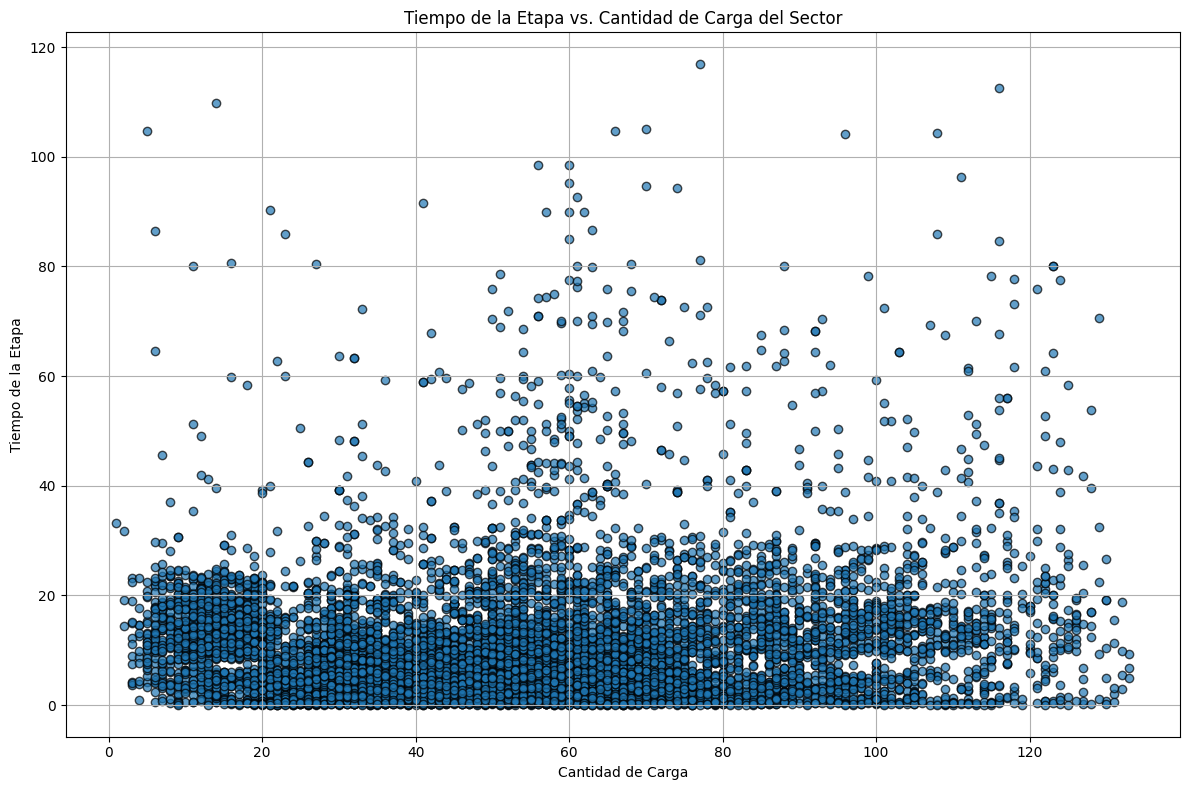

In [261]:
import matplotlib.pyplot as plt

# Convertir el tiempo en formato HH:MM a horas decimales
def convertir_a_horas(tiempo_horas):
    h, m = map(int, tiempo_horas.split(':'))
    return h + m / 60  # Convertir minutos a fracción de hora

df['Horas Tarea Neto (horas)'] = df['Horas Tarea Neto'].apply(convertir_a_horas)


# Crear la figura
plt.figure(figsize=(12, 8))

# Crear el scatter plot
plt.scatter(df['carga_trabajo_sector'], df['Horas Tarea Neto (horas)'], alpha=0.7, edgecolors='k')

# Personalizar el gráfico
plt.title('Tiempo de la Etapa vs. Cantidad de Carga del Sector')
plt.xlabel('Cantidad de Carga')
plt.ylabel('Tiempo de la Etapa')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


### Cantidad de sectores

In [262]:
# cantidad de etapas

# Contar la cantidad de registros por ID y agregar como nueva columna
df['cantidad_etapas'] = df.groupby('Nº')['Sector'].transform('nunique')

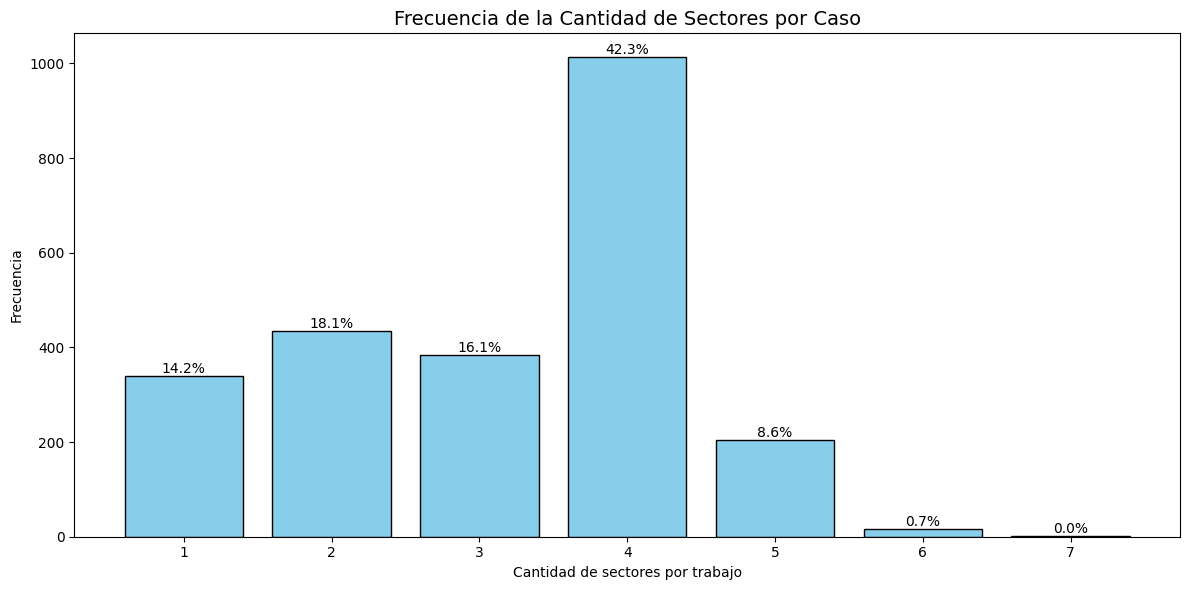

In [263]:
# Distribución de la cantidad de sectores

# Agrupar por 'Job_ID' y obtener una sola cantidad de dientes por ID
dientes_por_id = df.groupby('Nº')['cantidad_etapas'].first()  # O usa .mean() si quieres un promedio en lugar del primer valor

# Contar la frecuencia de cada cantidad de dientes
frecuencias = dientes_por_id.value_counts().sort_index()  # Ordenar por el índice para asegurar un gráfico correcto

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(frecuencias.index, frecuencias, color='skyblue', edgecolor='black')

# Calcular los porcentajes
total = frecuencias.sum()
percentages = (frecuencias / total) * 100

# Etiquetar cada barra con su porcentaje
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

# Agregar títulos y etiquetas
plt.title("Frecuencia de la Cantidad de Sectores por Caso", fontsize=14)
plt.xlabel("Cantidad de sectores por trabajo")
plt.ylabel("Frecuencia")
plt.tight_layout()

# Mostrar el gráfico
plt.show()


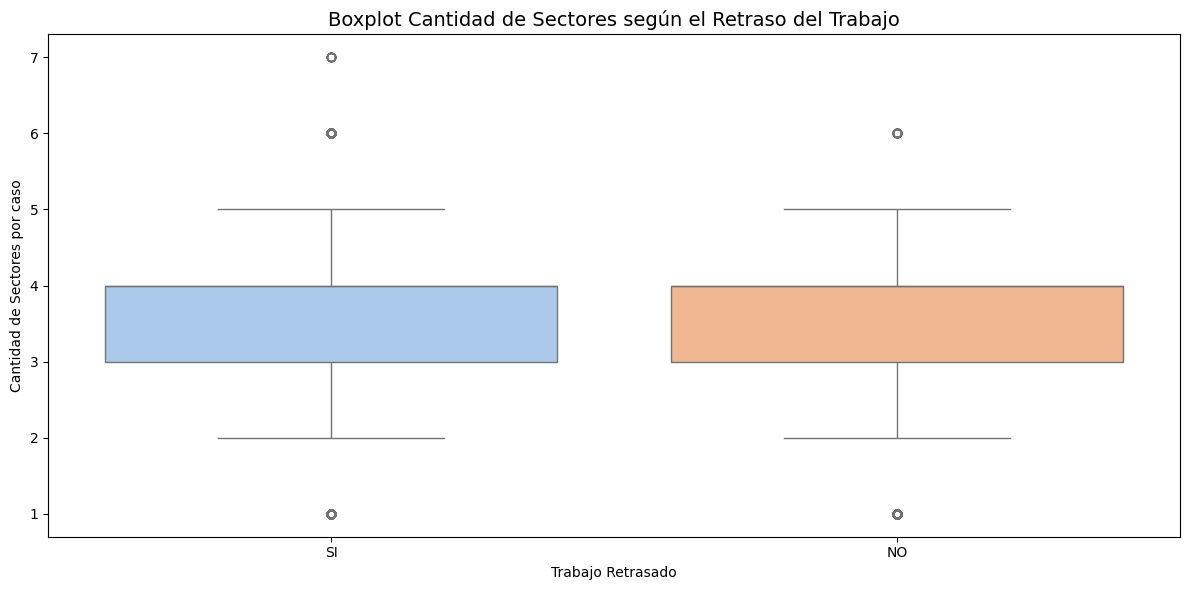

In [264]:
# boxplot de la Cantidad de Dientes según el Retraso

# Crear un gráfico de cajas para visualizar la distribución de la cantidad de dientes
plt.figure(figsize=(12, 6))
sns.boxplot(x='Atrasado', y='cantidad_etapas', data=df, palette='pastel')

# Agregar títulos y etiquetas
plt.title("Boxplot Cantidad de Sectores según el Retraso del Trabajo", fontsize=14)
plt.xlabel("Trabajo Retrasado")
plt.ylabel("Cantidad de Sectores por caso")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [265]:
# Mann-Whitney U: atraso vs cantidad de etapas

# Separar los datos en dos grupos: atrasado y no atrasado
grupo_atrasado = df[df['Atrasado'] == 'SI']['cantidad_etapas']
grupo_no_atrasado = df[df['Atrasado'] == 'NO']['cantidad_etapas']

    # Realizar la prueba de Mann-Whitney U
u_stat, p_val = stats.mannwhitneyu(grupo_atrasado, grupo_no_atrasado, alternative='two-sided')

print(f'Estadístico U: {u_stat:.3f}')
print(f'Valor p: {p_val:.3f}')

# Interpretación
alpha = 0.05
if p_val < alpha:
    print('Hay una diferencia significativa entre los grupos.')
else:
    print('No hay una diferencia significativa entre los grupos.')


Estadístico U: 18385939.000
Valor p: 0.000
Hay una diferencia significativa entre los grupos.


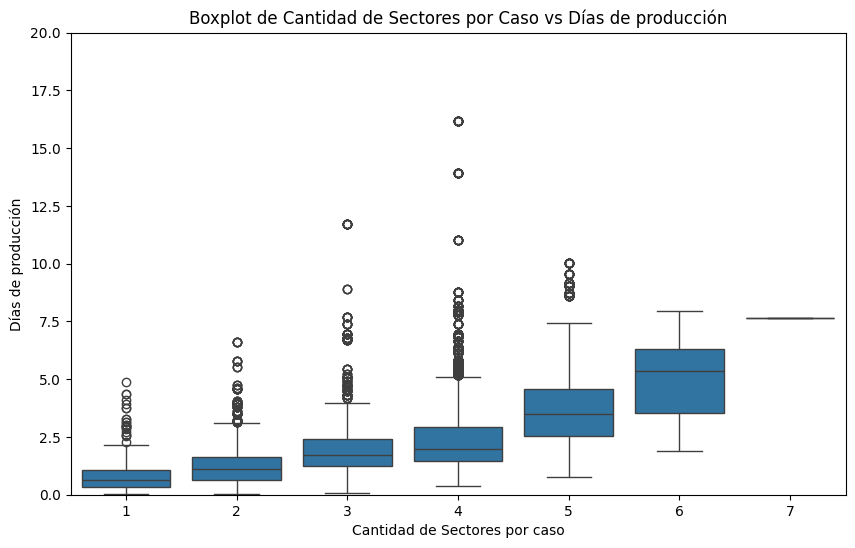

In [266]:
# Boxplot de Cantidad de sectores por caso vs Días de Atraso 

# Crea el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='cantidad_etapas', y='Días Pedido Neto', data=df)

# Añade etiquetas y título
plt.xlabel('Cantidad de Sectores por caso')
plt.ylabel('Días de producción')
plt.title('Boxplot de Cantidad de Sectores por Caso vs Días de producción')

plt.ylim(0, 20)

# Muestra el plot
plt.show()

In [267]:
# Agrupar los datos por cantidad de etapas
grupos = [grupo['Días Pedido Neto'].values for nombre, grupo in df.groupby('Sector')]

# Realizar el ANOVA
anova_result = stats.f_oneway(*grupos)

print('F-statistic:', anova_result.statistic)
print('p-value:', anova_result.pvalue)

F-statistic: 31.927185877950006
p-value: 2.479624237303451e-38
